In [1]:
""" Import_libraries"""
# Load libraries
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification

# Set random seed
# fix random seed for reproducibility
np.random.seed(7)

Using TensorFlow backend.
C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df

In [3]:
"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(path):
    
    SolubilityData = read_csv(path) # read csv
    
    chems=[] # variable to store the 
    
#     print("List loaded:\n") # view the list
#     print(SolubilityData)
    
    # change column names of 
    SolubilityData.rename(columns={ SolubilityData.columns[1]: "Solubility" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
    SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)
    
    for row in range(0,len(SolubilityData['SMILES'])):
        chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
    SolubilityData['SMILES'] = chems
    return SolubilityData # return the data list which contains the three input

#     chems = SolubilityData['SMILES'] # read columns
#     compounds =  SolubilityData['Compound ID']
#     solubilities = SolubilityData['measured log(solubility:mol/L)']
    
#     data = {"chems": chems,
#             "compounds": compounds,
#             "solubilities": solubilities,


data = load_chemicals("C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")

In [4]:
"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs

In [5]:
""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
depth = 4
train_y_b4=np.zeros((1,len(data['Solubility'])))
fpSize = 1024
tc = tensorChem(data['SMILES'],fpSize, depth)
print('The original vector shape:\n'+str(tc.shape))
# The flattened vector shape
train_x_flatten = tc.reshape(tc.shape[0], -1).T
print('The flattened vector shape:\n '+str(train_x_flatten.shape))
# The shape of label vector
train_y_b4[0]=np.squeeze(data['Solubility'])
print('The solubility vector shape:\n '+str(train_y_b4.shape))

The original vector shape:
(1144, 1024, 4)
The flattened vector shape:
 (4096, 1144)
The solubility vector shape:
 (1, 1144)


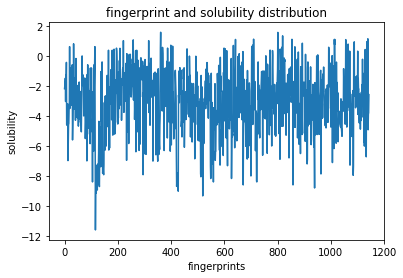

The mean of the solubility is: -3.0579973776223777
The S.D. of the solubility is: 2.0955854254462576


C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


'In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function \nof a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population\nare made, based on a finite data sample.'

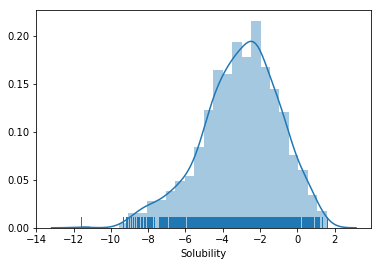

In [6]:
""" Visualize solubility """
# plot the solubility distribution
plt.plot(np.squeeze(train_y_b4))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution" )
plt.show()

# plot the histogram of solubility
import seaborn as sns
train_y_plot = pd.Series( np.squeeze(train_y_b4), name="Solubility")
mean = train_y_b4.mean()
std = train_y_b4.std()
print("The mean of the solubility is: " + str(mean))
print("The S.D. of the solubility is: " + str(std))
sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
"""In statistics, kernel density estimation (KDE) is a non-parametric way to estimate the probability density function 
of a random variable. Kernel density estimation is a fundamental data smoothing problem where inferences about the population
are made, based on a finite data sample."""

There are 606 soluble chemicals (positive samples) and 538 insoluble chemicals (negative samples).


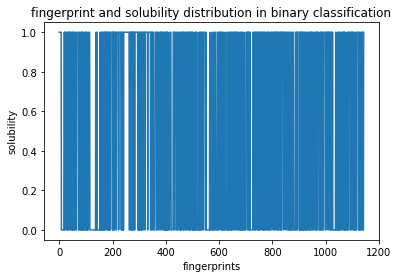

In [16]:
""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
train_y=np.zeros((1,len(data['Solubility'])))
for i in range(0,len(train_y_b4[0])):
    if (train_y_b4[0][i] >=mean):
        train_y[0][i]=1
    else:
        train_y[0][i]=0

print('There are '+ str(list(np.squeeze(train_y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(train_y)).count(0)) + ' insoluble chemicals (negative samples).')
        
# plot the input fingerprint length distribution plot
plt.plot(np.squeeze(train_y))
plt.ylabel('solubility')
plt.xlabel('fingerprints')
plt.title("fingerprint and solubility distribution in binary classification" )
plt.show()


In [7]:
"""This initially creates clusters of points normally distributed (std=1) about vertices of an n_informative-dimensional hypercube with sides of length 2*class_sep and assigns an equal number of clusters to each class. It introduces interdependence between these features and adds various types of further noise to the data."""
# Number of features
number_of_features = 4096
# Generate features matrix and target vector
features, target = make_classification(n_samples = 1144,
                                       n_features = number_of_features,
                                       n_informative = 3,
                                       n_redundant = 0,
                                       n_classes = 2,
                                       weights = [.5, .5],
                                       random_state = 0)

In [60]:
"""Hardmax Network"""
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations))
def create_network_binary_classifier():
    
    # Start neural network
    network = models.Sequential()

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=20, activation='relu', input_shape=(number_of_features,)))
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=7, activation='relu'))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=5, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1, activation='sigmoid'))
    
    # Setup hyperparameters for Adam optimizer
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    
    # Compile neural network
    network.compile(loss='binary_crossentropy', # Cross-entropy
                    optimizer= Adam, # Root Mean Square Propagation
                    metrics=['accuracy']) # Accuracy performance metric
  
    # Return compiled network
    return network

In [17]:
"""Linear Regression Network"""

from keras import backend as K

# Customized R2 ACC method
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations))
def create_network_linear_regression():
    
    # Start neural network
    network = models.Sequential()
    
    # Add fully connected layer with a ReLU activation function; He init no bias
    # network.add(layers.Dense(units=20,activation='relu', input_shape=(number_of_features,),use_bias=False)) # Random_init no bias
    # network.add(layers.Dense(units=20,activation='relu', input_shape=(number_of_features,),kernel_initializer='he_normal')) # He_init with bias
    network.add(layers.Dense(units=20,activation='relu', input_shape=(number_of_features,))) # Random_init with bias
    
    
    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=7, activation='relu'))

    # Add fully connected layer with a ReLU activation function
    network.add(layers.Dense(units=5, activation='relu'))

    # Add fully connected layer with a sigmoid activation function
    network.add(layers.Dense(units=1))
    
    # Setup hyperparameters for Adam optimizer
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    
    # Compile neural network
    network.compile(loss='mean_squared_error', # Cross-entropy
                    optimizer= Adam, # Root Mean Square Propagation
                    metrics=[coeff_determination]) # Accuracy performance metric-R2
  
    # Return compiled network
    return network

In [9]:
import statsmodels.api as sm
import math

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return r_squared

def get_r2_scipy(x, y):
    _, _, r_value, _, _ = stats.linregress(x, y)
    return r_value**2

def get_r2_statsmodels(x, y):
    return sm.OLS(y, sm.add_constant(x)).fit().rsquared

In [10]:
# define the training visualization function
def training_vis(hist,name):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    acc = hist.history['coeff_determination']
    val_acc = hist.history['val_coeff_determination']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    ax2.plot(acc,label='train_coeff_determination')
    ax2.plot(val_acc,label='val_coeff_determination')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Coeff_determination')
    ax2.set_title('Coeff_determination  on Training and Validation Data')
    ax2.legend()
    plt.tight_layout()
    plt.savefig(name, bbox_inches='tight')
    plt. close()

In [11]:
"""StratifiedKFold"""
from scipy import stats
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib

pic_path='C:/Users/DR/Desktop/P2/Latent-master/pic/BGD_RandomInit_WithBias/'

def k_folds_NN(X=train_x_flatten.T,Y=train_y_b4.T,batch_size=1144, epochs=500,path='C:/Users/DR/Desktop/P2/Latent-master/pic/BGD_RandomInit_WithBias/'):
    train_xx=X
    train_yy=train_y_b4.T
    # Split the dataset in 3 folds
    sfolder = KFold(n_splits=3,random_state=0,shuffle=True)
    sfolder.get_n_splits(train_xx,train_yy)



    network=create_network_linear_regression()
    predict=[]
    train_=[]
    i=0

    for i, (train, test) in enumerate(sfolder.split(train_xx,train_yy)):
        X_train, X_test = train_xx[train], train_xx[test]
        y_train, y_test = train_yy[train], train_yy[test]

        # Train the model with each combination of folds
        network=create_network_linear_regression()
        hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))
        network.save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
        train_.append(network.predict(X_train))
        predict.append(network.predict(X_test))
        training_vis(hist,path+"train_fold "+str(i+1)+".svg")
        plt.cla()
        

        r_square=get_r2_statsmodels(train_[i],y_train)
        q_square=get_r2_statsmodels(predict[i],y_test)

        model=LinearRegression()
        model.fit(train_[i],y_train)
#        plt.cla()
        ax=plt.gca()
        plt.scatter(train_[i],y_train)
        y_train_pred=model.predict(train_[i])
        plt.title('Linear regression of solubility training prediction in fold '+str(i+1))
        plt.text(0.5,0.7,"The R-square value is %.2f " % r_square, verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(train_[i],y_train_pred,color='black',linewidth=3,label="R-square")
        plt.legend(loc=2)
        plt.xlabel("train  (mol/L)")
        plt.ylabel("theorical  (mol/L)")
#        plt.show()
#        plt.savefig(path+'R2_'+str(i+1)+'.svg', bbox_inches='tight')
#        plt.close()

        model=LinearRegression()
        model.fit(predict[i],y_test)
#        plt.cla()
#        ax=plt.gca()
        plt.scatter(predict[i],y_test)
        y_train_pred=model.predict(predict[i])
#        plt.title('Linear regression of solubility prediction in fold '+str(i))
        plt.text(0.5,0.645,"The Q-square value is %.2f " % q_square,verticalalignment='bottom',color='red', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(predict[i],y_train_pred,color='red',linewidth=3,label="Q-square")
        plt.legend(loc=2)
#        plt.xlabel("predict  (mol/L)")
#        plt.ylabel("theorical  (mol/L)")
#        plt.show()
        
        plt.savefig(path+'linear_regression_fold_'+str(i+1)+'.svg', bbox_inches='tight')
        plt.close()

        i=i+1

In [12]:
# no_bias; Random_Init
history=k_folds_NN(X=train_x_flatten.T,Y=train_y_b4.T,batch_size=1144, epochs=500,path='C:/Users/DR/Desktop/P2/Latent-master/pic/BGD_RandomInit_NoBias/')

Train on 762 samples, validate on 382 samples
Epoch 1/500
762/762 [==============================] - 0s 364us/step - loss: 13.5107 - coeff_determination: -2.0456 - val_loss: 10.5751 - val_coeff_determination: -1.4580
Epoch 2/500
762/762 [==============================] - 0s 72us/step - loss: 10.9078 - coeff_determination: -1.4589 - val_loss: 7.9929 - val_coeff_determination: -0.8578
Epoch 3/500
762/762 [==============================] - 0s 60us/step - loss: 8.3337 - coeff_determination: -0.8786 - val_loss: 6.3989 - val_coeff_determination: -0.4873
Epoch 4/500
762/762 [==============================] - 0s 56us/step - loss: 6.5921 - coeff_determination: -0.4860 - val_loss: 6.1686 - val_coeff_determination: -0.4338
Epoch 5/500
762/762 [==============================] - 0s 54us/step - loss: 6.1320 - coeff_determination: -0.3823 - val_loss: 6.5855 - val_coeff_determination: -0.5307
Epoch 6/500
762/762 [==============================] - 0s 60us/step - loss: 6.3678 - coeff_determination: -0.4

Epoch 50/500
762/762 [==============================] - 0s 63us/step - loss: 0.8431 - coeff_determination: 0.8100 - val_loss: 1.3429 - val_coeff_determination: 0.6879
Epoch 51/500
762/762 [==============================] - 0s 54us/step - loss: 0.8254 - coeff_determination: 0.8139 - val_loss: 1.3309 - val_coeff_determination: 0.6907
Epoch 52/500
762/762 [==============================] - 0s 62us/step - loss: 0.8066 - coeff_determination: 0.8182 - val_loss: 1.3187 - val_coeff_determination: 0.6935
Epoch 53/500
762/762 [==============================] - 0s 66us/step - loss: 0.7886 - coeff_determination: 0.8222 - val_loss: 1.3082 - val_coeff_determination: 0.6959
Epoch 54/500
762/762 [==============================] - 0s 62us/step - loss: 0.7724 - coeff_determination: 0.8259 - val_loss: 1.2978 - val_coeff_determination: 0.6984
Epoch 55/500
762/762 [==============================] - 0s 58us/step - loss: 0.7578 - coeff_determination: 0.8292 - val_loss: 1.2882 - val_coeff_determination: 0.700

762/762 [==============================] - 0s 55us/step - loss: 0.4866 - coeff_determination: 0.8903 - val_loss: 1.1882 - val_coeff_determination: 0.7238
Epoch 100/500
762/762 [==============================] - 0s 58us/step - loss: 0.4842 - coeff_determination: 0.8909 - val_loss: 1.1893 - val_coeff_determination: 0.7236
Epoch 101/500
762/762 [==============================] - 0s 47us/step - loss: 0.4818 - coeff_determination: 0.8914 - val_loss: 1.1904 - val_coeff_determination: 0.7233
Epoch 102/500
762/762 [==============================] - 0s 84us/step - loss: 0.4797 - coeff_determination: 0.8919 - val_loss: 1.1914 - val_coeff_determination: 0.7231
Epoch 103/500
762/762 [==============================] - 0s 45us/step - loss: 0.4778 - coeff_determination: 0.8923 - val_loss: 1.1921 - val_coeff_determination: 0.7229
Epoch 104/500
762/762 [==============================] - 0s 72us/step - loss: 0.4758 - coeff_determination: 0.8927 - val_loss: 1.1925 - val_coeff_determination: 0.7228
Epoch 

Epoch 148/500
762/762 [==============================] - 0s 63us/step - loss: 0.4101 - coeff_determination: 0.9076 - val_loss: 1.2804 - val_coeff_determination: 0.7024
Epoch 149/500
762/762 [==============================] - 0s 59us/step - loss: 0.4090 - coeff_determination: 0.9078 - val_loss: 1.2824 - val_coeff_determination: 0.7019
Epoch 150/500
762/762 [==============================] - 0s 63us/step - loss: 0.4079 - coeff_determination: 0.9080 - val_loss: 1.2856 - val_coeff_determination: 0.7012
Epoch 151/500
762/762 [==============================] - 0s 58us/step - loss: 0.4067 - coeff_determination: 0.9083 - val_loss: 1.2899 - val_coeff_determination: 0.7002
Epoch 152/500
762/762 [==============================] - 0s 59us/step - loss: 0.4055 - coeff_determination: 0.9086 - val_loss: 1.2947 - val_coeff_determination: 0.6991
Epoch 153/500
762/762 [==============================] - 0s 64us/step - loss: 0.4044 - coeff_determination: 0.9088 - val_loss: 1.2998 - val_coeff_determination:

Epoch 197/500
762/762 [==============================] - 0s 59us/step - loss: 0.3628 - coeff_determination: 0.9182 - val_loss: 1.4447 - val_coeff_determination: 0.6642
Epoch 198/500
762/762 [==============================] - 0s 62us/step - loss: 0.3619 - coeff_determination: 0.9184 - val_loss: 1.4509 - val_coeff_determination: 0.6628
Epoch 199/500
762/762 [==============================] - 0s 60us/step - loss: 0.3611 - coeff_determination: 0.9186 - val_loss: 1.4558 - val_coeff_determination: 0.6616
Epoch 200/500
762/762 [==============================] - 0s 59us/step - loss: 0.3606 - coeff_determination: 0.9187 - val_loss: 1.4587 - val_coeff_determination: 0.6609
Epoch 201/500
762/762 [==============================] - 0s 60us/step - loss: 0.3598 - coeff_determination: 0.9189 - val_loss: 1.4593 - val_coeff_determination: 0.6608
Epoch 202/500
762/762 [==============================] - 0s 52us/step - loss: 0.3590 - coeff_determination: 0.9191 - val_loss: 1.4593 - val_coeff_determination:

Epoch 246/500
762/762 [==============================] - 0s 63us/step - loss: 0.3364 - coeff_determination: 0.9242 - val_loss: 1.5851 - val_coeff_determination: 0.6316
Epoch 247/500
762/762 [==============================] - 0s 60us/step - loss: 0.3360 - coeff_determination: 0.9243 - val_loss: 1.5865 - val_coeff_determination: 0.6313
Epoch 248/500
762/762 [==============================] - 0s 49us/step - loss: 0.3357 - coeff_determination: 0.9243 - val_loss: 1.5881 - val_coeff_determination: 0.6309
Epoch 249/500
762/762 [==============================] - 0s 71us/step - loss: 0.3353 - coeff_determination: 0.9244 - val_loss: 1.5916 - val_coeff_determination: 0.6301
Epoch 250/500
762/762 [==============================] - 0s 60us/step - loss: 0.3350 - coeff_determination: 0.9245 - val_loss: 1.5947 - val_coeff_determination: 0.6293
Epoch 251/500
762/762 [==============================] - 0s 60us/step - loss: 0.3346 - coeff_determination: 0.9246 - val_loss: 1.5959 - val_coeff_determination:

Epoch 295/500
762/762 [==============================] - 0s 58us/step - loss: 0.3213 - coeff_determination: 0.9276 - val_loss: 1.6678 - val_coeff_determination: 0.6124
Epoch 296/500
762/762 [==============================] - 0s 60us/step - loss: 0.3211 - coeff_determination: 0.9276 - val_loss: 1.6680 - val_coeff_determination: 0.6123
Epoch 297/500
762/762 [==============================] - 0s 71us/step - loss: 0.3208 - coeff_determination: 0.9277 - val_loss: 1.6697 - val_coeff_determination: 0.6119
Epoch 298/500
762/762 [==============================] - 0s 54us/step - loss: 0.3205 - coeff_determination: 0.9277 - val_loss: 1.6718 - val_coeff_determination: 0.6114
Epoch 299/500
762/762 [==============================] - 0s 46us/step - loss: 0.3203 - coeff_determination: 0.9278 - val_loss: 1.6721 - val_coeff_determination: 0.6114
Epoch 300/500
762/762 [==============================] - 0s 77us/step - loss: 0.3201 - coeff_determination: 0.9279 - val_loss: 1.6739 - val_coeff_determination:

Epoch 344/500
762/762 [==============================] - 0s 60us/step - loss: 0.3114 - coeff_determination: 0.9298 - val_loss: 1.7203 - val_coeff_determination: 0.6001
Epoch 345/500
762/762 [==============================] - 0s 59us/step - loss: 0.3112 - coeff_determination: 0.9298 - val_loss: 1.7180 - val_coeff_determination: 0.6007
Epoch 346/500
762/762 [==============================] - 0s 45us/step - loss: 0.3111 - coeff_determination: 0.9299 - val_loss: 1.7271 - val_coeff_determination: 0.5986
Epoch 347/500
762/762 [==============================] - 0s 82us/step - loss: 0.3110 - coeff_determination: 0.9299 - val_loss: 1.7182 - val_coeff_determination: 0.6006
Epoch 348/500
762/762 [==============================] - 0s 60us/step - loss: 0.3109 - coeff_determination: 0.9299 - val_loss: 1.7329 - val_coeff_determination: 0.5972
Epoch 349/500
762/762 [==============================] - 0s 66us/step - loss: 0.3108 - coeff_determination: 0.9299 - val_loss: 1.7198 - val_coeff_determination:

Epoch 393/500
762/762 [==============================] - 0s 62us/step - loss: 0.3068 - coeff_determination: 0.9308 - val_loss: 1.8023 - val_coeff_determination: 0.5811
Epoch 394/500
762/762 [==============================] - 0s 59us/step - loss: 0.3059 - coeff_determination: 0.9310 - val_loss: 1.7634 - val_coeff_determination: 0.5901
Epoch 395/500
762/762 [==============================] - 0s 66us/step - loss: 0.3049 - coeff_determination: 0.9313 - val_loss: 1.7858 - val_coeff_determination: 0.5849
Epoch 396/500
762/762 [==============================] - 0s 63us/step - loss: 0.3040 - coeff_determination: 0.9315 - val_loss: 1.7804 - val_coeff_determination: 0.5862
Epoch 397/500
762/762 [==============================] - 0s 64us/step - loss: 0.3036 - coeff_determination: 0.9316 - val_loss: 1.7763 - val_coeff_determination: 0.5871
Epoch 398/500
762/762 [==============================] - 0s 65us/step - loss: 0.3037 - coeff_determination: 0.9315 - val_loss: 1.7971 - val_coeff_determination:

Epoch 442/500
762/762 [==============================] - 0s 59us/step - loss: 0.3034 - coeff_determination: 0.9316 - val_loss: 1.8100 - val_coeff_determination: 0.5793
Epoch 443/500
762/762 [==============================] - 0s 63us/step - loss: 0.3037 - coeff_determination: 0.9315 - val_loss: 1.8755 - val_coeff_determination: 0.5641
Epoch 444/500
762/762 [==============================] - 0s 64us/step - loss: 0.3014 - coeff_determination: 0.9321 - val_loss: 1.8290 - val_coeff_determination: 0.5749
Epoch 445/500
762/762 [==============================] - 0s 67us/step - loss: 0.2992 - coeff_determination: 0.9326 - val_loss: 1.8407 - val_coeff_determination: 0.5722
Epoch 446/500
762/762 [==============================] - 0s 47us/step - loss: 0.2984 - coeff_determination: 0.9327 - val_loss: 1.8544 - val_coeff_determination: 0.5690
Epoch 447/500
762/762 [==============================] - 0s 72us/step - loss: 0.2988 - coeff_determination: 0.9326 - val_loss: 1.8230 - val_coeff_determination:

Epoch 491/500
762/762 [==============================] - 0s 66us/step - loss: 0.2944 - coeff_determination: 0.9336 - val_loss: 1.9062 - val_coeff_determination: 0.5569
Epoch 492/500
762/762 [==============================] - 0s 62us/step - loss: 0.2942 - coeff_determination: 0.9337 - val_loss: 1.9084 - val_coeff_determination: 0.5564
Epoch 493/500
762/762 [==============================] - 0s 70us/step - loss: 0.2941 - coeff_determination: 0.9337 - val_loss: 1.9128 - val_coeff_determination: 0.5554
Epoch 494/500
762/762 [==============================] - 0s 60us/step - loss: 0.2940 - coeff_determination: 0.9337 - val_loss: 1.9077 - val_coeff_determination: 0.5566
Epoch 495/500
762/762 [==============================] - 0s 62us/step - loss: 0.2940 - coeff_determination: 0.9337 - val_loss: 1.9250 - val_coeff_determination: 0.5526
Epoch 496/500
762/762 [==============================] - 0s 56us/step - loss: 0.2941 - coeff_determination: 0.9337 - val_loss: 1.9008 - val_coeff_determination:

Epoch 40/500
763/763 [==============================] - 0s 60us/step - loss: 1.4421 - coeff_determination: 0.6714 - val_loss: 2.1850 - val_coeff_determination: 0.5021
Epoch 41/500
763/763 [==============================] - 0s 50us/step - loss: 1.4036 - coeff_determination: 0.6801 - val_loss: 2.1381 - val_coeff_determination: 0.5128
Epoch 42/500
763/763 [==============================] - 0s 76us/step - loss: 1.3660 - coeff_determination: 0.6887 - val_loss: 2.0971 - val_coeff_determination: 0.5221
Epoch 43/500
763/763 [==============================] - 0s 60us/step - loss: 1.3350 - coeff_determination: 0.6958 - val_loss: 2.0596 - val_coeff_determination: 0.5307
Epoch 44/500
763/763 [==============================] - 0s 64us/step - loss: 1.3058 - coeff_determination: 0.7024 - val_loss: 2.0185 - val_coeff_determination: 0.5400
Epoch 45/500
763/763 [==============================] - 0s 64us/step - loss: 1.2775 - coeff_determination: 0.7089 - val_loss: 1.9767 - val_coeff_determination: 0.549

763/763 [==============================] - 0s 71us/step - loss: 0.5609 - coeff_determination: 0.8722 - val_loss: 1.4378 - val_coeff_determination: 0.6723
Epoch 90/500
763/763 [==============================] - 0s 67us/step - loss: 0.5541 - coeff_determination: 0.8737 - val_loss: 1.4353 - val_coeff_determination: 0.6729
Epoch 91/500
763/763 [==============================] - 0s 62us/step - loss: 0.5474 - coeff_determination: 0.8753 - val_loss: 1.4329 - val_coeff_determination: 0.6735
Epoch 92/500
763/763 [==============================] - 0s 68us/step - loss: 0.5411 - coeff_determination: 0.8767 - val_loss: 1.4308 - val_coeff_determination: 0.6739
Epoch 93/500
763/763 [==============================] - 0s 60us/step - loss: 0.5349 - coeff_determination: 0.8781 - val_loss: 1.4294 - val_coeff_determination: 0.6743
Epoch 94/500
763/763 [==============================] - 0s 56us/step - loss: 0.5289 - coeff_determination: 0.8795 - val_loss: 1.4286 - val_coeff_determination: 0.6744
Epoch 95/50

Epoch 138/500
763/763 [==============================] - 0s 63us/step - loss: 0.3954 - coeff_determination: 0.9099 - val_loss: 1.4464 - val_coeff_determination: 0.6704
Epoch 139/500
763/763 [==============================] - 0s 63us/step - loss: 0.3940 - coeff_determination: 0.9102 - val_loss: 1.4468 - val_coeff_determination: 0.6703
Epoch 140/500
763/763 [==============================] - 0s 63us/step - loss: 0.3927 - coeff_determination: 0.9105 - val_loss: 1.4470 - val_coeff_determination: 0.6703
Epoch 141/500
763/763 [==============================] - 0s 61us/step - loss: 0.3914 - coeff_determination: 0.9108 - val_loss: 1.4473 - val_coeff_determination: 0.6702
Epoch 142/500
763/763 [==============================] - 0s 68us/step - loss: 0.3901 - coeff_determination: 0.9111 - val_loss: 1.4479 - val_coeff_determination: 0.6701
Epoch 143/500
763/763 [==============================] - 0s 64us/step - loss: 0.3889 - coeff_determination: 0.9114 - val_loss: 1.4487 - val_coeff_determination:

Epoch 187/500
763/763 [==============================] - 0s 67us/step - loss: 0.3478 - coeff_determination: 0.9207 - val_loss: 1.4787 - val_coeff_determination: 0.6630
Epoch 188/500
763/763 [==============================] - 0s 52us/step - loss: 0.3470 - coeff_determination: 0.9209 - val_loss: 1.4802 - val_coeff_determination: 0.6627
Epoch 189/500
763/763 [==============================] - 0s 83us/step - loss: 0.3463 - coeff_determination: 0.9211 - val_loss: 1.4816 - val_coeff_determination: 0.6624
Epoch 190/500
763/763 [==============================] - 0s 59us/step - loss: 0.3456 - coeff_determination: 0.9212 - val_loss: 1.4831 - val_coeff_determination: 0.6620
Epoch 191/500
763/763 [==============================] - 0s 51us/step - loss: 0.3450 - coeff_determination: 0.9214 - val_loss: 1.4845 - val_coeff_determination: 0.6617
Epoch 192/500
763/763 [==============================] - 0s 71us/step - loss: 0.3443 - coeff_determination: 0.9215 - val_loss: 1.4856 - val_coeff_determination:

Epoch 236/500
763/763 [==============================] - 0s 64us/step - loss: 0.3203 - coeff_determination: 0.9270 - val_loss: 1.5266 - val_coeff_determination: 0.6521
Epoch 237/500
763/763 [==============================] - 0s 60us/step - loss: 0.3199 - coeff_determination: 0.9271 - val_loss: 1.5272 - val_coeff_determination: 0.6520
Epoch 238/500
763/763 [==============================] - 0s 62us/step - loss: 0.3195 - coeff_determination: 0.9272 - val_loss: 1.5277 - val_coeff_determination: 0.6519
Epoch 239/500
763/763 [==============================] - 0s 71us/step - loss: 0.3190 - coeff_determination: 0.9273 - val_loss: 1.5281 - val_coeff_determination: 0.6518
Epoch 240/500
763/763 [==============================] - 0s 59us/step - loss: 0.3186 - coeff_determination: 0.9274 - val_loss: 1.5290 - val_coeff_determination: 0.6516
Epoch 241/500
763/763 [==============================] - 0s 68us/step - loss: 0.3182 - coeff_determination: 0.9275 - val_loss: 1.5300 - val_coeff_determination:

Epoch 285/500
763/763 [==============================] - 0s 68us/step - loss: 0.3023 - coeff_determination: 0.9311 - val_loss: 1.5381 - val_coeff_determination: 0.6495
Epoch 286/500
763/763 [==============================] - 0s 59us/step - loss: 0.3020 - coeff_determination: 0.9312 - val_loss: 1.5384 - val_coeff_determination: 0.6494
Epoch 287/500
763/763 [==============================] - 0s 62us/step - loss: 0.3017 - coeff_determination: 0.9313 - val_loss: 1.5378 - val_coeff_determination: 0.6496
Epoch 288/500
763/763 [==============================] - 0s 73us/step - loss: 0.3014 - coeff_determination: 0.9313 - val_loss: 1.5370 - val_coeff_determination: 0.6497
Epoch 289/500
763/763 [==============================] - 0s 56us/step - loss: 0.3011 - coeff_determination: 0.9314 - val_loss: 1.5368 - val_coeff_determination: 0.6498
Epoch 290/500
763/763 [==============================] - 0s 67us/step - loss: 0.3008 - coeff_determination: 0.9315 - val_loss: 1.5367 - val_coeff_determination:

Epoch 334/500
763/763 [==============================] - 0s 67us/step - loss: 0.2888 - coeff_determination: 0.9342 - val_loss: 1.5349 - val_coeff_determination: 0.6502
Epoch 335/500
763/763 [==============================] - 0s 72us/step - loss: 0.2886 - coeff_determination: 0.9342 - val_loss: 1.5350 - val_coeff_determination: 0.6502
Epoch 336/500
763/763 [==============================] - 0s 69us/step - loss: 0.2884 - coeff_determination: 0.9343 - val_loss: 1.5354 - val_coeff_determination: 0.6501
Epoch 337/500
763/763 [==============================] - 0s 66us/step - loss: 0.2881 - coeff_determination: 0.9343 - val_loss: 1.5356 - val_coeff_determination: 0.6501
Epoch 338/500
763/763 [==============================] - 0s 69us/step - loss: 0.2879 - coeff_determination: 0.9344 - val_loss: 1.5360 - val_coeff_determination: 0.6500
Epoch 339/500
763/763 [==============================] - 0s 68us/step - loss: 0.2877 - coeff_determination: 0.9344 - val_loss: 1.5359 - val_coeff_determination:

Epoch 383/500
763/763 [==============================] - 0s 58us/step - loss: 0.2789 - coeff_determination: 0.9365 - val_loss: 1.5504 - val_coeff_determination: 0.6467
Epoch 384/500
763/763 [==============================] - 0s 56us/step - loss: 0.2787 - coeff_determination: 0.9365 - val_loss: 1.5509 - val_coeff_determination: 0.6466
Epoch 385/500
763/763 [==============================] - 0s 66us/step - loss: 0.2785 - coeff_determination: 0.9365 - val_loss: 1.5510 - val_coeff_determination: 0.6466
Epoch 386/500
763/763 [==============================] - 0s 61us/step - loss: 0.2784 - coeff_determination: 0.9366 - val_loss: 1.5519 - val_coeff_determination: 0.6463
Epoch 387/500
763/763 [==============================] - 0s 63us/step - loss: 0.2782 - coeff_determination: 0.9366 - val_loss: 1.5526 - val_coeff_determination: 0.6462
Epoch 388/500
763/763 [==============================] - 0s 62us/step - loss: 0.2780 - coeff_determination: 0.9367 - val_loss: 1.5529 - val_coeff_determination:

Epoch 432/500
763/763 [==============================] - 0s 59us/step - loss: 0.2713 - coeff_determination: 0.9382 - val_loss: 1.5626 - val_coeff_determination: 0.6439
Epoch 433/500
763/763 [==============================] - 0s 60us/step - loss: 0.2712 - coeff_determination: 0.9382 - val_loss: 1.5623 - val_coeff_determination: 0.6440
Epoch 434/500
763/763 [==============================] - 0s 50us/step - loss: 0.2711 - coeff_determination: 0.9382 - val_loss: 1.5623 - val_coeff_determination: 0.6440
Epoch 435/500
763/763 [==============================] - 0s 76us/step - loss: 0.2710 - coeff_determination: 0.9383 - val_loss: 1.5617 - val_coeff_determination: 0.6441
Epoch 436/500
763/763 [==============================] - 0s 58us/step - loss: 0.2709 - coeff_determination: 0.9383 - val_loss: 1.5631 - val_coeff_determination: 0.6438
Epoch 437/500
763/763 [==============================] - 0s 66us/step - loss: 0.2708 - coeff_determination: 0.9383 - val_loss: 1.5626 - val_coeff_determination:

Epoch 481/500
763/763 [==============================] - 0s 63us/step - loss: 0.2675 - coeff_determination: 0.9390 - val_loss: 1.5771 - val_coeff_determination: 0.6406
Epoch 482/500
763/763 [==============================] - 0s 60us/step - loss: 0.2665 - coeff_determination: 0.9393 - val_loss: 1.5790 - val_coeff_determination: 0.6402
Epoch 483/500
763/763 [==============================] - 0s 66us/step - loss: 0.2657 - coeff_determination: 0.9394 - val_loss: 1.5793 - val_coeff_determination: 0.6401
Epoch 484/500
763/763 [==============================] - 0s 67us/step - loss: 0.2655 - coeff_determination: 0.9395 - val_loss: 1.5790 - val_coeff_determination: 0.6402
Epoch 485/500
763/763 [==============================] - 0s 63us/step - loss: 0.2658 - coeff_determination: 0.9394 - val_loss: 1.5817 - val_coeff_determination: 0.6396
Epoch 486/500
763/763 [==============================] - 0s 63us/step - loss: 0.2661 - coeff_determination: 0.9393 - val_loss: 1.5796 - val_coeff_determination:

Epoch 30/500
763/763 [==============================] - 0s 60us/step - loss: 1.1267 - coeff_determination: 0.7408 - val_loss: 1.4450 - val_coeff_determination: 0.6769
Epoch 31/500
763/763 [==============================] - 0s 52us/step - loss: 1.0880 - coeff_determination: 0.7497 - val_loss: 1.4123 - val_coeff_determination: 0.6842
Epoch 32/500
763/763 [==============================] - 0s 88us/step - loss: 1.0494 - coeff_determination: 0.7586 - val_loss: 1.3887 - val_coeff_determination: 0.6895
Epoch 33/500
763/763 [==============================] - 0s 58us/step - loss: 1.0205 - coeff_determination: 0.7652 - val_loss: 1.3763 - val_coeff_determination: 0.6923
Epoch 34/500
763/763 [==============================] - 0s 71us/step - loss: 1.0021 - coeff_determination: 0.7695 - val_loss: 1.3673 - val_coeff_determination: 0.6943
Epoch 35/500
763/763 [==============================] - 0s 64us/step - loss: 0.9872 - coeff_determination: 0.7729 - val_loss: 1.3540 - val_coeff_determination: 0.697

763/763 [==============================] - 0s 66us/step - loss: 0.5012 - coeff_determination: 0.8847 - val_loss: 1.2834 - val_coeff_determination: 0.7131
Epoch 80/500
763/763 [==============================] - 0s 72us/step - loss: 0.4974 - coeff_determination: 0.8856 - val_loss: 1.2845 - val_coeff_determination: 0.7128
Epoch 81/500
763/763 [==============================] - 0s 59us/step - loss: 0.4938 - coeff_determination: 0.8864 - val_loss: 1.2875 - val_coeff_determination: 0.7121
Epoch 82/500
763/763 [==============================] - 0s 70us/step - loss: 0.4901 - coeff_determination: 0.8873 - val_loss: 1.2916 - val_coeff_determination: 0.7112
Epoch 83/500
763/763 [==============================] - 0s 66us/step - loss: 0.4865 - coeff_determination: 0.8881 - val_loss: 1.2955 - val_coeff_determination: 0.7103
Epoch 84/500
763/763 [==============================] - 0s 58us/step - loss: 0.4830 - coeff_determination: 0.8889 - val_loss: 1.2981 - val_coeff_determination: 0.7098
Epoch 85/50

Epoch 128/500
763/763 [==============================] - 0s 72us/step - loss: 0.3777 - coeff_determination: 0.9131 - val_loss: 1.3248 - val_coeff_determination: 0.7038
Epoch 129/500
763/763 [==============================] - 0s 64us/step - loss: 0.3761 - coeff_determination: 0.9135 - val_loss: 1.3248 - val_coeff_determination: 0.7038
Epoch 130/500
763/763 [==============================] - 0s 66us/step - loss: 0.3747 - coeff_determination: 0.9138 - val_loss: 1.3255 - val_coeff_determination: 0.7036
Epoch 131/500
763/763 [==============================] - 0s 62us/step - loss: 0.3733 - coeff_determination: 0.9141 - val_loss: 1.3259 - val_coeff_determination: 0.7036
Epoch 132/500
763/763 [==============================] - 0s 45us/step - loss: 0.3718 - coeff_determination: 0.9145 - val_loss: 1.3268 - val_coeff_determination: 0.7034
Epoch 133/500
763/763 [==============================] - 0s 80us/step - loss: 0.3705 - coeff_determination: 0.9148 - val_loss: 1.3291 - val_coeff_determination:

Epoch 177/500
763/763 [==============================] - 0s 59us/step - loss: 0.3332 - coeff_determination: 0.9234 - val_loss: 1.3837 - val_coeff_determination: 0.6906
Epoch 178/500
763/763 [==============================] - 0s 62us/step - loss: 0.3327 - coeff_determination: 0.9235 - val_loss: 1.3846 - val_coeff_determination: 0.6904
Epoch 179/500
763/763 [==============================] - 0s 62us/step - loss: 0.3321 - coeff_determination: 0.9236 - val_loss: 1.3856 - val_coeff_determination: 0.6902
Epoch 180/500
763/763 [==============================] - 0s 64us/step - loss: 0.3316 - coeff_determination: 0.9237 - val_loss: 1.3876 - val_coeff_determination: 0.6897
Epoch 181/500
763/763 [==============================] - 0s 62us/step - loss: 0.3311 - coeff_determination: 0.9238 - val_loss: 1.3897 - val_coeff_determination: 0.6893
Epoch 182/500
763/763 [==============================] - 0s 62us/step - loss: 0.3306 - coeff_determination: 0.9240 - val_loss: 1.3896 - val_coeff_determination:

Epoch 226/500
763/763 [==============================] - 0s 63us/step - loss: 0.3139 - coeff_determination: 0.9278 - val_loss: 1.4353 - val_coeff_determination: 0.6791
Epoch 227/500
763/763 [==============================] - 0s 71us/step - loss: 0.3136 - coeff_determination: 0.9279 - val_loss: 1.4353 - val_coeff_determination: 0.6791
Epoch 228/500
763/763 [==============================] - 0s 64us/step - loss: 0.3133 - coeff_determination: 0.9279 - val_loss: 1.4359 - val_coeff_determination: 0.6790
Epoch 229/500
763/763 [==============================] - 0s 64us/step - loss: 0.3131 - coeff_determination: 0.9280 - val_loss: 1.4353 - val_coeff_determination: 0.6791
Epoch 230/500
763/763 [==============================] - 0s 59us/step - loss: 0.3128 - coeff_determination: 0.9280 - val_loss: 1.4363 - val_coeff_determination: 0.6789
Epoch 231/500
763/763 [==============================] - 0s 66us/step - loss: 0.3125 - coeff_determination: 0.9281 - val_loss: 1.4376 - val_coeff_determination:

Epoch 275/500
763/763 [==============================] - 0s 63us/step - loss: 0.3042 - coeff_determination: 0.9300 - val_loss: 1.4775 - val_coeff_determination: 0.6696
Epoch 276/500
763/763 [==============================] - 0s 66us/step - loss: 0.3041 - coeff_determination: 0.9301 - val_loss: 1.4776 - val_coeff_determination: 0.6696
Epoch 277/500
763/763 [==============================] - 0s 60us/step - loss: 0.3039 - coeff_determination: 0.9301 - val_loss: 1.4813 - val_coeff_determination: 0.6688
Epoch 278/500
763/763 [==============================] - 0s 47us/step - loss: 0.3037 - coeff_determination: 0.9301 - val_loss: 1.4824 - val_coeff_determination: 0.6686
Epoch 279/500
763/763 [==============================] - 0s 80us/step - loss: 0.3036 - coeff_determination: 0.9302 - val_loss: 1.4810 - val_coeff_determination: 0.6689
Epoch 280/500
763/763 [==============================] - 0s 61us/step - loss: 0.3035 - coeff_determination: 0.9302 - val_loss: 1.4819 - val_coeff_determination:

Epoch 324/500
763/763 [==============================] - 0s 79us/step - loss: 0.2983 - coeff_determination: 0.9314 - val_loss: 1.5124 - val_coeff_determination: 0.6618
Epoch 325/500
763/763 [==============================] - 0s 67us/step - loss: 0.2982 - coeff_determination: 0.9314 - val_loss: 1.5135 - val_coeff_determination: 0.6616
Epoch 326/500
763/763 [==============================] - 0s 56us/step - loss: 0.2981 - coeff_determination: 0.9314 - val_loss: 1.5131 - val_coeff_determination: 0.6617
Epoch 327/500
763/763 [==============================] - 0s 67us/step - loss: 0.2980 - coeff_determination: 0.9315 - val_loss: 1.5149 - val_coeff_determination: 0.6613
Epoch 328/500
763/763 [==============================] - 0s 60us/step - loss: 0.2979 - coeff_determination: 0.9315 - val_loss: 1.5160 - val_coeff_determination: 0.6610
Epoch 329/500
763/763 [==============================] - 0s 67us/step - loss: 0.2978 - coeff_determination: 0.9315 - val_loss: 1.5149 - val_coeff_determination:

Epoch 373/500
763/763 [==============================] - 0s 62us/step - loss: 0.2941 - coeff_determination: 0.9323 - val_loss: 1.5388 - val_coeff_determination: 0.6560
Epoch 374/500
763/763 [==============================] - 0s 58us/step - loss: 0.2940 - coeff_determination: 0.9324 - val_loss: 1.5388 - val_coeff_determination: 0.6559
Epoch 375/500
763/763 [==============================] - 0s 63us/step - loss: 0.2939 - coeff_determination: 0.9324 - val_loss: 1.5417 - val_coeff_determination: 0.6553
Epoch 376/500
763/763 [==============================] - 0s 60us/step - loss: 0.2939 - coeff_determination: 0.9324 - val_loss: 1.5399 - val_coeff_determination: 0.6557
Epoch 377/500
763/763 [==============================] - 0s 67us/step - loss: 0.2939 - coeff_determination: 0.9324 - val_loss: 1.5451 - val_coeff_determination: 0.6545
Epoch 378/500
763/763 [==============================] - 0s 56us/step - loss: 0.2939 - coeff_determination: 0.9324 - val_loss: 1.5385 - val_coeff_determination:

Epoch 422/500
763/763 [==============================] - 0s 67us/step - loss: 0.2906 - coeff_determination: 0.9332 - val_loss: 1.5660 - val_coeff_determination: 0.6499
Epoch 423/500
763/763 [==============================] - 0s 75us/step - loss: 0.2907 - coeff_determination: 0.9331 - val_loss: 1.5618 - val_coeff_determination: 0.6508
Epoch 424/500
763/763 [==============================] - 0s 66us/step - loss: 0.2909 - coeff_determination: 0.9331 - val_loss: 1.5712 - val_coeff_determination: 0.6487
Epoch 425/500
763/763 [==============================] - 0s 68us/step - loss: 0.2912 - coeff_determination: 0.9330 - val_loss: 1.5604 - val_coeff_determination: 0.6511
Epoch 426/500
763/763 [==============================] - 0s 68us/step - loss: 0.2914 - coeff_determination: 0.9330 - val_loss: 1.5710 - val_coeff_determination: 0.6487
Epoch 427/500
763/763 [==============================] - 0s 62us/step - loss: 0.2915 - coeff_determination: 0.9329 - val_loss: 1.5570 - val_coeff_determination:

Epoch 471/500
763/763 [==============================] - 0s 67us/step - loss: 0.2890 - coeff_determination: 0.9335 - val_loss: 1.5815 - val_coeff_determination: 0.6464
Epoch 472/500
763/763 [==============================] - 0s 64us/step - loss: 0.2888 - coeff_determination: 0.9336 - val_loss: 1.5691 - val_coeff_determination: 0.6492
Epoch 473/500
763/763 [==============================] - 0s 63us/step - loss: 0.2884 - coeff_determination: 0.9337 - val_loss: 1.5754 - val_coeff_determination: 0.6478
Epoch 474/500
763/763 [==============================] - 0s 64us/step - loss: 0.2880 - coeff_determination: 0.9338 - val_loss: 1.5728 - val_coeff_determination: 0.6483
Epoch 475/500
763/763 [==============================] - 0s 66us/step - loss: 0.2877 - coeff_determination: 0.9338 - val_loss: 1.5721 - val_coeff_determination: 0.6485
Epoch 476/500
763/763 [==============================] - 0s 66us/step - loss: 0.2877 - coeff_determination: 0.9338 - val_loss: 1.5775 - val_coeff_determination:

In [18]:
# with_bias; Random_Init
history=k_folds_NN(X=train_x_flatten.T,Y=train_y_b4.T,batch_size=1144, epochs=500,path='C:/Users/DR/Desktop/P2/Latent-master/pic/BGD_RandomInit_WithBias/')

Train on 762 samples, validate on 382 samples
Epoch 1/500
762/762 [==============================] - 1s 683us/step - loss: 14.0271 - coeff_determination: -2.1620 - val_loss: 13.3277 - val_coeff_determination: -2.0978
Epoch 2/500
762/762 [==============================] - 0s 69us/step - loss: 13.5623 - coeff_determination: -2.0573 - val_loss: 12.7229 - val_coeff_determination: -1.9572
Epoch 3/500
762/762 [==============================] - 0s 59us/step - loss: 12.9729 - coeff_determination: -1.9244 - val_loss: 11.9468 - val_coeff_determination: -1.7768
Epoch 4/500
762/762 [==============================] - 0s 55us/step - loss: 12.2071 - coeff_determination: -1.7518 - val_loss: 11.0129 - val_coeff_determination: -1.5597
Epoch 5/500
762/762 [==============================] - 0s 64us/step - loss: 11.2729 - coeff_determination: -1.5412 - val_loss: 9.9440 - val_coeff_determination: -1.3113
Epoch 6/500
762/762 [==============================] - 0s 66us/step - loss: 10.1876 - coeff_determinatio

Epoch 50/500
762/762 [==============================] - 0s 81us/step - loss: 1.4169 - coeff_determination: 0.6806 - val_loss: 1.7259 - val_coeff_determination: 0.5989
Epoch 51/500
762/762 [==============================] - 0s 71us/step - loss: 1.3933 - coeff_determination: 0.6859 - val_loss: 1.7034 - val_coeff_determination: 0.6041
Epoch 52/500
762/762 [==============================] - 0s 75us/step - loss: 1.3691 - coeff_determination: 0.6914 - val_loss: 1.6829 - val_coeff_determination: 0.6089
Epoch 53/500
762/762 [==============================] - 0s 63us/step - loss: 1.3438 - coeff_determination: 0.6971 - val_loss: 1.6635 - val_coeff_determination: 0.6133
Epoch 54/500
762/762 [==============================] - 0s 63us/step - loss: 1.3177 - coeff_determination: 0.7030 - val_loss: 1.6486 - val_coeff_determination: 0.6168
Epoch 55/500
762/762 [==============================] - 0s 68us/step - loss: 1.2934 - coeff_determination: 0.7084 - val_loss: 1.6388 - val_coeff_determination: 0.619

762/762 [==============================] - 0s 64us/step - loss: 0.6871 - coeff_determination: 0.8451 - val_loss: 1.2937 - val_coeff_determination: 0.6993
Epoch 100/500
762/762 [==============================] - 0s 62us/step - loss: 0.6786 - coeff_determination: 0.8470 - val_loss: 1.2907 - val_coeff_determination: 0.7000
Epoch 101/500
762/762 [==============================] - 0s 76us/step - loss: 0.6700 - coeff_determination: 0.8490 - val_loss: 1.2874 - val_coeff_determination: 0.7008
Epoch 102/500
762/762 [==============================] - 0s 81us/step - loss: 0.6616 - coeff_determination: 0.8509 - val_loss: 1.2826 - val_coeff_determination: 0.7019
Epoch 103/500
762/762 [==============================] - 0s 71us/step - loss: 0.6532 - coeff_determination: 0.8528 - val_loss: 1.2781 - val_coeff_determination: 0.7029
Epoch 104/500
762/762 [==============================] - 0s 64us/step - loss: 0.6449 - coeff_determination: 0.8546 - val_loss: 1.2770 - val_coeff_determination: 0.7032
Epoch 

Epoch 148/500
762/762 [==============================] - 0s 64us/step - loss: 0.4269 - coeff_determination: 0.9038 - val_loss: 1.3171 - val_coeff_determination: 0.6939
Epoch 149/500
762/762 [==============================] - 0s 64us/step - loss: 0.4237 - coeff_determination: 0.9045 - val_loss: 1.3145 - val_coeff_determination: 0.6945
Epoch 150/500
762/762 [==============================] - 0s 60us/step - loss: 0.4212 - coeff_determination: 0.9050 - val_loss: 1.3149 - val_coeff_determination: 0.6944
Epoch 151/500
762/762 [==============================] - 0s 67us/step - loss: 0.4186 - coeff_determination: 0.9056 - val_loss: 1.3200 - val_coeff_determination: 0.6932
Epoch 152/500
762/762 [==============================] - 0s 62us/step - loss: 0.4150 - coeff_determination: 0.9064 - val_loss: 1.3252 - val_coeff_determination: 0.6920
Epoch 153/500
762/762 [==============================] - 0s 63us/step - loss: 0.4123 - coeff_determination: 0.9070 - val_loss: 1.3264 - val_coeff_determination:

Epoch 197/500
762/762 [==============================] - 0s 64us/step - loss: 0.3354 - coeff_determination: 0.9244 - val_loss: 1.3694 - val_coeff_determination: 0.6817
Epoch 198/500
762/762 [==============================] - 0s 62us/step - loss: 0.3339 - coeff_determination: 0.9247 - val_loss: 1.3686 - val_coeff_determination: 0.6819
Epoch 199/500
762/762 [==============================] - 0s 76us/step - loss: 0.3332 - coeff_determination: 0.9249 - val_loss: 1.3736 - val_coeff_determination: 0.6807
Epoch 200/500
762/762 [==============================] - 0s 55us/step - loss: 0.3322 - coeff_determination: 0.9251 - val_loss: 1.3721 - val_coeff_determination: 0.6811
Epoch 201/500
762/762 [==============================] - 0s 75us/step - loss: 0.3312 - coeff_determination: 0.9253 - val_loss: 1.3715 - val_coeff_determination: 0.6812
Epoch 202/500
762/762 [==============================] - 0s 73us/step - loss: 0.3303 - coeff_determination: 0.9255 - val_loss: 1.3731 - val_coeff_determination:

Epoch 246/500
762/762 [==============================] - 0s 63us/step - loss: 0.3057 - coeff_determination: 0.9311 - val_loss: 1.4033 - val_coeff_determination: 0.6738
Epoch 247/500
762/762 [==============================] - 0s 58us/step - loss: 0.3055 - coeff_determination: 0.9311 - val_loss: 1.4201 - val_coeff_determination: 0.6699
Epoch 248/500
762/762 [==============================] - 0s 65us/step - loss: 0.3057 - coeff_determination: 0.9311 - val_loss: 1.4006 - val_coeff_determination: 0.6745
Epoch 249/500
762/762 [==============================] - 0s 60us/step - loss: 0.3048 - coeff_determination: 0.9313 - val_loss: 1.4121 - val_coeff_determination: 0.6718
Epoch 250/500
762/762 [==============================] - 0s 57us/step - loss: 0.3039 - coeff_determination: 0.9315 - val_loss: 1.4170 - val_coeff_determination: 0.6706
Epoch 251/500
762/762 [==============================] - 0s 67us/step - loss: 0.3033 - coeff_determination: 0.9316 - val_loss: 1.4099 - val_coeff_determination:

Epoch 295/500
762/762 [==============================] - 0s 63us/step - loss: 0.2939 - coeff_determination: 0.9338 - val_loss: 1.4424 - val_coeff_determination: 0.6647
Epoch 296/500
762/762 [==============================] - 0s 62us/step - loss: 0.2938 - coeff_determination: 0.9338 - val_loss: 1.4357 - val_coeff_determination: 0.6663
Epoch 297/500
762/762 [==============================] - 0s 61us/step - loss: 0.2935 - coeff_determination: 0.9338 - val_loss: 1.4465 - val_coeff_determination: 0.6638
Epoch 298/500
762/762 [==============================] - 0s 70us/step - loss: 0.2932 - coeff_determination: 0.9339 - val_loss: 1.4374 - val_coeff_determination: 0.6659
Epoch 299/500
762/762 [==============================] - 0s 65us/step - loss: 0.2928 - coeff_determination: 0.9340 - val_loss: 1.4432 - val_coeff_determination: 0.6646
Epoch 300/500
762/762 [==============================] - 0s 64us/step - loss: 0.2926 - coeff_determination: 0.9340 - val_loss: 1.4503 - val_coeff_determination:

Epoch 344/500
762/762 [==============================] - 0s 75us/step - loss: 0.2884 - coeff_determination: 0.9350 - val_loss: 1.4844 - val_coeff_determination: 0.6550
Epoch 345/500
762/762 [==============================] - 0s 75us/step - loss: 0.2879 - coeff_determination: 0.9351 - val_loss: 1.4883 - val_coeff_determination: 0.6541
Epoch 346/500
762/762 [==============================] - 0s 75us/step - loss: 0.2879 - coeff_determination: 0.9351 - val_loss: 1.4833 - val_coeff_determination: 0.6552
Epoch 347/500
762/762 [==============================] - 0s 70us/step - loss: 0.2880 - coeff_determination: 0.9351 - val_loss: 1.4899 - val_coeff_determination: 0.6537
Epoch 348/500
762/762 [==============================] - 0s 65us/step - loss: 0.2880 - coeff_determination: 0.9351 - val_loss: 1.4867 - val_coeff_determination: 0.6544
Epoch 349/500
762/762 [==============================] - 0s 80us/step - loss: 0.2878 - coeff_determination: 0.9351 - val_loss: 1.4877 - val_coeff_determination:

Epoch 393/500
762/762 [==============================] - 0s 67us/step - loss: 0.2860 - coeff_determination: 0.9355 - val_loss: 1.5337 - val_coeff_determination: 0.6435
Epoch 394/500
762/762 [==============================] - 0s 63us/step - loss: 0.2870 - coeff_determination: 0.9353 - val_loss: 1.5238 - val_coeff_determination: 0.6458
Epoch 395/500
762/762 [==============================] - 0s 55us/step - loss: 0.2881 - coeff_determination: 0.9350 - val_loss: 1.5386 - val_coeff_determination: 0.6424
Epoch 396/500
762/762 [==============================] - 0s 85us/step - loss: 0.2886 - coeff_determination: 0.9349 - val_loss: 1.5267 - val_coeff_determination: 0.6452
Epoch 397/500
762/762 [==============================] - 0s 45us/step - loss: 0.2876 - coeff_determination: 0.9352 - val_loss: 1.5348 - val_coeff_determination: 0.6433
Epoch 398/500
762/762 [==============================] - 0s 86us/step - loss: 0.2861 - coeff_determination: 0.9355 - val_loss: 1.5312 - val_coeff_determination:

Epoch 442/500
762/762 [==============================] - 0s 62us/step - loss: 0.2839 - coeff_determination: 0.9360 - val_loss: 1.5549 - val_coeff_determination: 0.6386
Epoch 443/500
762/762 [==============================] - 0s 64us/step - loss: 0.2835 - coeff_determination: 0.9361 - val_loss: 1.5585 - val_coeff_determination: 0.6378
Epoch 444/500
762/762 [==============================] - 0s 69us/step - loss: 0.2835 - coeff_determination: 0.9361 - val_loss: 1.5666 - val_coeff_determination: 0.6359
Epoch 445/500
762/762 [==============================] - 0s 60us/step - loss: 0.2839 - coeff_determination: 0.9360 - val_loss: 1.5610 - val_coeff_determination: 0.6372
Epoch 446/500
762/762 [==============================] - 0s 71us/step - loss: 0.2844 - coeff_determination: 0.9359 - val_loss: 1.5594 - val_coeff_determination: 0.6375
Epoch 447/500
762/762 [==============================] - 0s 59us/step - loss: 0.2849 - coeff_determination: 0.9358 - val_loss: 1.5624 - val_coeff_determination:

Epoch 491/500
762/762 [==============================] - 0s 67us/step - loss: 0.2829 - coeff_determination: 0.9362 - val_loss: 1.5794 - val_coeff_determination: 0.6329
Epoch 492/500
762/762 [==============================] - 0s 63us/step - loss: 0.2832 - coeff_determination: 0.9361 - val_loss: 1.5670 - val_coeff_determination: 0.6358
Epoch 493/500
762/762 [==============================] - 0s 70us/step - loss: 0.2832 - coeff_determination: 0.9362 - val_loss: 1.5717 - val_coeff_determination: 0.6347
Epoch 494/500
762/762 [==============================] - 0s 68us/step - loss: 0.2836 - coeff_determination: 0.9361 - val_loss: 1.5816 - val_coeff_determination: 0.6324
Epoch 495/500
762/762 [==============================] - 0s 59us/step - loss: 0.2839 - coeff_determination: 0.9360 - val_loss: 1.5724 - val_coeff_determination: 0.6345
Epoch 496/500
762/762 [==============================] - 0s 69us/step - loss: 0.2836 - coeff_determination: 0.9361 - val_loss: 1.5761 - val_coeff_determination:

Epoch 40/500
763/763 [==============================] - 0s 64us/step - loss: 1.6424 - coeff_determination: 0.6257 - val_loss: 2.4104 - val_coeff_determination: 0.4507
Epoch 41/500
763/763 [==============================] - 0s 60us/step - loss: 1.6229 - coeff_determination: 0.6302 - val_loss: 2.3905 - val_coeff_determination: 0.4552
Epoch 42/500
763/763 [==============================] - 0s 64us/step - loss: 1.5974 - coeff_determination: 0.6360 - val_loss: 2.3606 - val_coeff_determination: 0.4621
Epoch 43/500
763/763 [==============================] - 0s 66us/step - loss: 1.5652 - coeff_determination: 0.6433 - val_loss: 2.3232 - val_coeff_determination: 0.4706
Epoch 44/500
763/763 [==============================] - 0s 67us/step - loss: 1.5285 - coeff_determination: 0.6517 - val_loss: 2.2827 - val_coeff_determination: 0.4798
Epoch 45/500
763/763 [==============================] - 0s 72us/step - loss: 1.4910 - coeff_determination: 0.6602 - val_loss: 2.2435 - val_coeff_determination: 0.488

763/763 [==============================] - 0s 66us/step - loss: 0.8092 - coeff_determination: 0.8156 - val_loss: 1.6455 - val_coeff_determination: 0.6250
Epoch 90/500
763/763 [==============================] - 0s 72us/step - loss: 0.8009 - coeff_determination: 0.8175 - val_loss: 1.6381 - val_coeff_determination: 0.6267
Epoch 91/500
763/763 [==============================] - 0s 64us/step - loss: 0.7928 - coeff_determination: 0.8193 - val_loss: 1.6306 - val_coeff_determination: 0.6284
Epoch 92/500
763/763 [==============================] - 0s 45us/step - loss: 0.7849 - coeff_determination: 0.8211 - val_loss: 1.6231 - val_coeff_determination: 0.6301
Epoch 93/500
763/763 [==============================] - 0s 73us/step - loss: 0.7772 - coeff_determination: 0.8229 - val_loss: 1.6159 - val_coeff_determination: 0.6318
Epoch 94/500
763/763 [==============================] - 0s 72us/step - loss: 0.7698 - coeff_determination: 0.8246 - val_loss: 1.6091 - val_coeff_determination: 0.6333
Epoch 95/50

Epoch 138/500
763/763 [==============================] - 0s 72us/step - loss: 0.5673 - coeff_determination: 0.8707 - val_loss: 1.4523 - val_coeff_determination: 0.6691
Epoch 139/500
763/763 [==============================] - 0s 67us/step - loss: 0.5645 - coeff_determination: 0.8714 - val_loss: 1.4500 - val_coeff_determination: 0.6696
Epoch 140/500
763/763 [==============================] - 0s 67us/step - loss: 0.5618 - coeff_determination: 0.8720 - val_loss: 1.4477 - val_coeff_determination: 0.6701
Epoch 141/500
763/763 [==============================] - 0s 67us/step - loss: 0.5591 - coeff_determination: 0.8726 - val_loss: 1.4454 - val_coeff_determination: 0.6706
Epoch 142/500
763/763 [==============================] - 0s 59us/step - loss: 0.5565 - coeff_determination: 0.8732 - val_loss: 1.4430 - val_coeff_determination: 0.6712
Epoch 143/500
763/763 [==============================] - 0s 66us/step - loss: 0.5539 - coeff_determination: 0.8738 - val_loss: 1.4405 - val_coeff_determination:

Epoch 187/500
763/763 [==============================] - 0s 66us/step - loss: 0.4729 - coeff_determination: 0.8922 - val_loss: 1.3922 - val_coeff_determination: 0.6827
Epoch 188/500
763/763 [==============================] - 0s 73us/step - loss: 0.4715 - coeff_determination: 0.8925 - val_loss: 1.3916 - val_coeff_determination: 0.6829
Epoch 189/500
763/763 [==============================] - 0s 72us/step - loss: 0.4703 - coeff_determination: 0.8928 - val_loss: 1.3912 - val_coeff_determination: 0.6830
Epoch 190/500
763/763 [==============================] - 0s 66us/step - loss: 0.4691 - coeff_determination: 0.8931 - val_loss: 1.3898 - val_coeff_determination: 0.6833
Epoch 191/500
763/763 [==============================] - 0s 51us/step - loss: 0.4665 - coeff_determination: 0.8937 - val_loss: 1.3874 - val_coeff_determination: 0.6838
Epoch 192/500
763/763 [==============================] - 0s 75us/step - loss: 0.4632 - coeff_determination: 0.8944 - val_loss: 1.3845 - val_coeff_determination:

Epoch 236/500
763/763 [==============================] - 0s 67us/step - loss: 0.3658 - coeff_determination: 0.9166 - val_loss: 1.4143 - val_coeff_determination: 0.6777
Epoch 237/500
763/763 [==============================] - 0s 69us/step - loss: 0.3648 - coeff_determination: 0.9169 - val_loss: 1.4161 - val_coeff_determination: 0.6773
Epoch 238/500
763/763 [==============================] - 0s 67us/step - loss: 0.3638 - coeff_determination: 0.9171 - val_loss: 1.4178 - val_coeff_determination: 0.6769
Epoch 239/500
763/763 [==============================] - 0s 69us/step - loss: 0.3628 - coeff_determination: 0.9173 - val_loss: 1.4190 - val_coeff_determination: 0.6766
Epoch 240/500
763/763 [==============================] - 0s 67us/step - loss: 0.3619 - coeff_determination: 0.9175 - val_loss: 1.4202 - val_coeff_determination: 0.6764
Epoch 241/500
763/763 [==============================] - 0s 51us/step - loss: 0.3609 - coeff_determination: 0.9178 - val_loss: 1.4217 - val_coeff_determination:

Epoch 285/500
763/763 [==============================] - 0s 68us/step - loss: 0.3300 - coeff_determination: 0.9248 - val_loss: 1.4703 - val_coeff_determination: 0.6649
Epoch 286/500
763/763 [==============================] - 0s 64us/step - loss: 0.3296 - coeff_determination: 0.9249 - val_loss: 1.4717 - val_coeff_determination: 0.6646
Epoch 287/500
763/763 [==============================] - 0s 65us/step - loss: 0.3291 - coeff_determination: 0.9250 - val_loss: 1.4731 - val_coeff_determination: 0.6643
Epoch 288/500
763/763 [==============================] - 0s 68us/step - loss: 0.3286 - coeff_determination: 0.9251 - val_loss: 1.4747 - val_coeff_determination: 0.6639
Epoch 289/500
763/763 [==============================] - 0s 63us/step - loss: 0.3281 - coeff_determination: 0.9252 - val_loss: 1.4765 - val_coeff_determination: 0.6635
Epoch 290/500
763/763 [==============================] - 0s 75us/step - loss: 0.3276 - coeff_determination: 0.9253 - val_loss: 1.4778 - val_coeff_determination:

Epoch 334/500
763/763 [==============================] - 0s 64us/step - loss: 0.3114 - coeff_determination: 0.9290 - val_loss: 1.5128 - val_coeff_determination: 0.6552
Epoch 335/500
763/763 [==============================] - 0s 63us/step - loss: 0.3111 - coeff_determination: 0.9291 - val_loss: 1.5134 - val_coeff_determination: 0.6551
Epoch 336/500
763/763 [==============================] - 0s 75us/step - loss: 0.3108 - coeff_determination: 0.9292 - val_loss: 1.5136 - val_coeff_determination: 0.6551
Epoch 337/500
763/763 [==============================] - 0s 52us/step - loss: 0.3106 - coeff_determination: 0.9292 - val_loss: 1.5141 - val_coeff_determination: 0.6550
Epoch 338/500
763/763 [==============================] - 0s 75us/step - loss: 0.3103 - coeff_determination: 0.9293 - val_loss: 1.5150 - val_coeff_determination: 0.6548
Epoch 339/500
763/763 [==============================] - 0s 68us/step - loss: 0.3100 - coeff_determination: 0.9294 - val_loss: 1.5159 - val_coeff_determination:

Epoch 383/500
763/763 [==============================] - 0s 71us/step - loss: 0.3004 - coeff_determination: 0.9316 - val_loss: 1.5357 - val_coeff_determination: 0.6500
Epoch 384/500
763/763 [==============================] - 0s 67us/step - loss: 0.3002 - coeff_determination: 0.9316 - val_loss: 1.5360 - val_coeff_determination: 0.6500
Epoch 385/500
763/763 [==============================] - 0s 63us/step - loss: 0.3000 - coeff_determination: 0.9316 - val_loss: 1.5364 - val_coeff_determination: 0.6499
Epoch 386/500
763/763 [==============================] - 0s 51us/step - loss: 0.2998 - coeff_determination: 0.9317 - val_loss: 1.5366 - val_coeff_determination: 0.6498
Epoch 387/500
763/763 [==============================] - 0s 82us/step - loss: 0.2996 - coeff_determination: 0.9317 - val_loss: 1.5370 - val_coeff_determination: 0.6498
Epoch 388/500
763/763 [==============================] - 0s 58us/step - loss: 0.2994 - coeff_determination: 0.9318 - val_loss: 1.5373 - val_coeff_determination:

Epoch 432/500
763/763 [==============================] - 0s 69us/step - loss: 0.2913 - coeff_determination: 0.9336 - val_loss: 1.5519 - val_coeff_determination: 0.6464
Epoch 433/500
763/763 [==============================] - 0s 69us/step - loss: 0.2911 - coeff_determination: 0.9337 - val_loss: 1.5521 - val_coeff_determination: 0.6463
Epoch 434/500
763/763 [==============================] - 0s 41us/step - loss: 0.2909 - coeff_determination: 0.9337 - val_loss: 1.5519 - val_coeff_determination: 0.6463
Epoch 435/500
763/763 [==============================] - 0s 63us/step - loss: 0.2907 - coeff_determination: 0.9338 - val_loss: 1.5522 - val_coeff_determination: 0.6463
Epoch 436/500
763/763 [==============================] - 0s 64us/step - loss: 0.2905 - coeff_determination: 0.9338 - val_loss: 1.5527 - val_coeff_determination: 0.6462
Epoch 437/500
763/763 [==============================] - 0s 61us/step - loss: 0.2903 - coeff_determination: 0.9338 - val_loss: 1.5534 - val_coeff_determination:

Epoch 481/500
763/763 [==============================] - 0s 75us/step - loss: 0.2821 - coeff_determination: 0.9357 - val_loss: 1.5628 - val_coeff_determination: 0.6439
Epoch 482/500
763/763 [==============================] - 0s 67us/step - loss: 0.2820 - coeff_determination: 0.9357 - val_loss: 1.5631 - val_coeff_determination: 0.6438
Epoch 483/500
763/763 [==============================] - 0s 68us/step - loss: 0.2819 - coeff_determination: 0.9358 - val_loss: 1.5635 - val_coeff_determination: 0.6437
Epoch 484/500
763/763 [==============================] - 0s 63us/step - loss: 0.2817 - coeff_determination: 0.9358 - val_loss: 1.5641 - val_coeff_determination: 0.6436
Epoch 485/500
763/763 [==============================] - 0s 54us/step - loss: 0.2816 - coeff_determination: 0.9358 - val_loss: 1.5651 - val_coeff_determination: 0.6433
Epoch 486/500
763/763 [==============================] - 0s 79us/step - loss: 0.2814 - coeff_determination: 0.9359 - val_loss: 1.5662 - val_coeff_determination:

Epoch 30/500
763/763 [==============================] - 0s 67us/step - loss: 3.6262 - coeff_determination: 0.1659 - val_loss: 3.2213 - val_coeff_determination: 0.2798
Epoch 31/500
763/763 [==============================] - 0s 64us/step - loss: 3.4352 - coeff_determination: 0.2098 - val_loss: 3.0522 - val_coeff_determination: 0.3176
Epoch 32/500
763/763 [==============================] - 0s 69us/step - loss: 3.2502 - coeff_determination: 0.2524 - val_loss: 2.9101 - val_coeff_determination: 0.3493
Epoch 33/500
763/763 [==============================] - 0s 54us/step - loss: 3.0886 - coeff_determination: 0.2895 - val_loss: 2.7943 - val_coeff_determination: 0.3752
Epoch 34/500
763/763 [==============================] - 0s 68us/step - loss: 2.9509 - coeff_determination: 0.3212 - val_loss: 2.6935 - val_coeff_determination: 0.3978
Epoch 35/500
763/763 [==============================] - 0s 59us/step - loss: 2.8311 - coeff_determination: 0.3488 - val_loss: 2.5947 - val_coeff_determination: 0.419

763/763 [==============================] - 0s 67us/step - loss: 0.9506 - coeff_determination: 0.7813 - val_loss: 1.4885 - val_coeff_determination: 0.6672
Epoch 80/500
763/763 [==============================] - 0s 72us/step - loss: 0.9375 - coeff_determination: 0.7843 - val_loss: 1.4927 - val_coeff_determination: 0.6663
Epoch 81/500
763/763 [==============================] - 0s 66us/step - loss: 0.9253 - coeff_determination: 0.7872 - val_loss: 1.4857 - val_coeff_determination: 0.6678
Epoch 82/500
763/763 [==============================] - 0s 62us/step - loss: 0.9137 - coeff_determination: 0.7898 - val_loss: 1.4877 - val_coeff_determination: 0.6674
Epoch 83/500
763/763 [==============================] - 0s 62us/step - loss: 0.9011 - coeff_determination: 0.7927 - val_loss: 1.4888 - val_coeff_determination: 0.6671
Epoch 84/500
763/763 [==============================] - 0s 64us/step - loss: 0.8900 - coeff_determination: 0.7953 - val_loss: 1.4815 - val_coeff_determination: 0.6688
Epoch 85/50

Epoch 128/500
763/763 [==============================] - 0s 64us/step - loss: 0.5959 - coeff_determination: 0.8629 - val_loss: 1.5609 - val_coeff_determination: 0.6510
Epoch 129/500
763/763 [==============================] - 0s 68us/step - loss: 0.5930 - coeff_determination: 0.8636 - val_loss: 1.5484 - val_coeff_determination: 0.6538
Epoch 130/500
763/763 [==============================] - 0s 72us/step - loss: 0.5906 - coeff_determination: 0.8641 - val_loss: 1.5656 - val_coeff_determination: 0.6500
Epoch 131/500
763/763 [==============================] - 0s 58us/step - loss: 0.5888 - coeff_determination: 0.8646 - val_loss: 1.5580 - val_coeff_determination: 0.6516
Epoch 132/500
763/763 [==============================] - 0s 70us/step - loss: 0.5852 - coeff_determination: 0.8654 - val_loss: 1.5796 - val_coeff_determination: 0.6468
Epoch 133/500
763/763 [==============================] - 0s 59us/step - loss: 0.5815 - coeff_determination: 0.8662 - val_loss: 1.5789 - val_coeff_determination:

Epoch 177/500
763/763 [==============================] - 0s 64us/step - loss: 0.5041 - coeff_determination: 0.8840 - val_loss: 1.6976 - val_coeff_determination: 0.6204
Epoch 178/500
763/763 [==============================] - 0s 75us/step - loss: 0.4980 - coeff_determination: 0.8855 - val_loss: 1.6768 - val_coeff_determination: 0.6251
Epoch 179/500
763/763 [==============================] - 0s 60us/step - loss: 0.4926 - coeff_determination: 0.8867 - val_loss: 1.6786 - val_coeff_determination: 0.6247
Epoch 180/500
763/763 [==============================] - 0s 64us/step - loss: 0.4910 - coeff_determination: 0.8871 - val_loss: 1.7018 - val_coeff_determination: 0.6195
Epoch 181/500
763/763 [==============================] - 0s 70us/step - loss: 0.4926 - coeff_determination: 0.8867 - val_loss: 1.6744 - val_coeff_determination: 0.6256
Epoch 182/500
763/763 [==============================] - 0s 59us/step - loss: 0.4964 - coeff_determination: 0.8858 - val_loss: 1.7165 - val_coeff_determination:

Epoch 226/500
763/763 [==============================] - 0s 68us/step - loss: 0.4423 - coeff_determination: 0.8983 - val_loss: 1.8212 - val_coeff_determination: 0.5928
Epoch 227/500
763/763 [==============================] - 0s 75us/step - loss: 0.4440 - coeff_determination: 0.8979 - val_loss: 1.7927 - val_coeff_determination: 0.5992
Epoch 228/500
763/763 [==============================] - 0s 67us/step - loss: 0.4480 - coeff_determination: 0.8969 - val_loss: 1.8432 - val_coeff_determination: 0.5879
Epoch 229/500
763/763 [==============================] - 0s 71us/step - loss: 0.4530 - coeff_determination: 0.8958 - val_loss: 1.7991 - val_coeff_determination: 0.5977
Epoch 230/500
763/763 [==============================] - 0s 63us/step - loss: 0.4565 - coeff_determination: 0.8950 - val_loss: 1.8583 - val_coeff_determination: 0.5845
Epoch 231/500
763/763 [==============================] - 0s 48us/step - loss: 0.4564 - coeff_determination: 0.8950 - val_loss: 1.8016 - val_coeff_determination:

Epoch 275/500
763/763 [==============================] - 0s 69us/step - loss: 0.4366 - coeff_determination: 0.8996 - val_loss: 2.0029 - val_coeff_determination: 0.5522
Epoch 276/500
763/763 [==============================] - 0s 68us/step - loss: 0.4524 - coeff_determination: 0.8959 - val_loss: 1.9186 - val_coeff_determination: 0.5710
Epoch 277/500
763/763 [==============================] - 0s 63us/step - loss: 0.4594 - coeff_determination: 0.8943 - val_loss: 1.9946 - val_coeff_determination: 0.5540
Epoch 278/500
763/763 [==============================] - 0s 67us/step - loss: 0.4456 - coeff_determination: 0.8975 - val_loss: 1.9050 - val_coeff_determination: 0.5741
Epoch 279/500
763/763 [==============================] - 0s 69us/step - loss: 0.4160 - coeff_determination: 0.9043 - val_loss: 1.9142 - val_coeff_determination: 0.5720
Epoch 280/500
763/763 [==============================] - 0s 76us/step - loss: 0.4026 - coeff_determination: 0.9074 - val_loss: 1.9528 - val_coeff_determination:

Epoch 324/500
763/763 [==============================] - 0s 67us/step - loss: 0.3805 - coeff_determination: 0.9125 - val_loss: 2.0064 - val_coeff_determination: 0.5514
Epoch 325/500
763/763 [==============================] - 0s 72us/step - loss: 0.3797 - coeff_determination: 0.9127 - val_loss: 2.0163 - val_coeff_determination: 0.5492
Epoch 326/500
763/763 [==============================] - 0s 72us/step - loss: 0.3791 - coeff_determination: 0.9128 - val_loss: 2.0153 - val_coeff_determination: 0.5494
Epoch 327/500
763/763 [==============================] - 0s 67us/step - loss: 0.3785 - coeff_determination: 0.9129 - val_loss: 2.0181 - val_coeff_determination: 0.5488
Epoch 328/500
763/763 [==============================] - 0s 64us/step - loss: 0.3781 - coeff_determination: 0.9130 - val_loss: 2.0217 - val_coeff_determination: 0.5480
Epoch 329/500
763/763 [==============================] - 0s 47us/step - loss: 0.3778 - coeff_determination: 0.9131 - val_loss: 2.0185 - val_coeff_determination:

Epoch 373/500
763/763 [==============================] - 0s 67us/step - loss: 0.3701 - coeff_determination: 0.9149 - val_loss: 2.0675 - val_coeff_determination: 0.5377
Epoch 374/500
763/763 [==============================] - 0s 62us/step - loss: 0.3700 - coeff_determination: 0.9149 - val_loss: 2.0270 - val_coeff_determination: 0.5468
Epoch 375/500
763/763 [==============================] - 0s 64us/step - loss: 0.3695 - coeff_determination: 0.9150 - val_loss: 2.0649 - val_coeff_determination: 0.5383
Epoch 376/500
763/763 [==============================] - 0s 75us/step - loss: 0.3686 - coeff_determination: 0.9152 - val_loss: 2.0303 - val_coeff_determination: 0.5460
Epoch 377/500
763/763 [==============================] - 0s 67us/step - loss: 0.3673 - coeff_determination: 0.9155 - val_loss: 2.0602 - val_coeff_determination: 0.5394
Epoch 378/500
763/763 [==============================] - 0s 68us/step - loss: 0.3660 - coeff_determination: 0.9158 - val_loss: 2.0375 - val_coeff_determination:

Epoch 422/500
763/763 [==============================] - 0s 67us/step - loss: 0.3612 - coeff_determination: 0.9169 - val_loss: 2.0468 - val_coeff_determination: 0.5424
Epoch 423/500
763/763 [==============================] - 0s 56us/step - loss: 0.3600 - coeff_determination: 0.9172 - val_loss: 2.0697 - val_coeff_determination: 0.5372
Epoch 424/500
763/763 [==============================] - 0s 72us/step - loss: 0.3571 - coeff_determination: 0.9179 - val_loss: 2.0640 - val_coeff_determination: 0.5385
Epoch 425/500
763/763 [==============================] - 0s 63us/step - loss: 0.3562 - coeff_determination: 0.9181 - val_loss: 2.0520 - val_coeff_determination: 0.5412
Epoch 426/500
763/763 [==============================] - 0s 71us/step - loss: 0.3577 - coeff_determination: 0.9177 - val_loss: 2.0807 - val_coeff_determination: 0.5348
Epoch 427/500
763/763 [==============================] - 0s 73us/step - loss: 0.3589 - coeff_determination: 0.9174 - val_loss: 2.0517 - val_coeff_determination:

Epoch 471/500
763/763 [==============================] - 0s 67us/step - loss: 0.3508 - coeff_determination: 0.9193 - val_loss: 2.0815 - val_coeff_determination: 0.5346
Epoch 472/500
763/763 [==============================] - 0s 72us/step - loss: 0.3508 - coeff_determination: 0.9193 - val_loss: 2.0941 - val_coeff_determination: 0.5318
Epoch 473/500
763/763 [==============================] - 0s 62us/step - loss: 0.3508 - coeff_determination: 0.9193 - val_loss: 2.0817 - val_coeff_determination: 0.5346
Epoch 474/500
763/763 [==============================] - 0s 65us/step - loss: 0.3507 - coeff_determination: 0.9193 - val_loss: 2.0957 - val_coeff_determination: 0.5314
Epoch 475/500
763/763 [==============================] - 0s 81us/step - loss: 0.3505 - coeff_determination: 0.9194 - val_loss: 2.0838 - val_coeff_determination: 0.5341
Epoch 476/500
763/763 [==============================] - 0s 64us/step - loss: 0.3504 - coeff_determination: 0.9194 - val_loss: 2.0979 - val_coeff_determination:

In [16]:
# with_bias; He_Init
k_folds_NN(X=train_x_flatten.T,Y=train_y_b4.T,batch_size=1144, epochs=500,path='C:/Users/DR/Desktop/P2/Latent-master/pic/BGD_HeInit_WithBias/')

Train on 762 samples, validate on 382 samples
Epoch 1/500
762/762 [==============================] - 0s 623us/step - loss: 14.2391 - coeff_determination: -2.2098 - val_loss: 14.3213 - val_coeff_determination: -2.3287
Epoch 2/500
762/762 [==============================] - 0s 54us/step - loss: 14.4502 - coeff_determination: -2.2574 - val_loss: 13.8746 - val_coeff_determination: -2.2249
Epoch 3/500
762/762 [==============================] - 0s 54us/step - loss: 14.0947 - coeff_determination: -2.1773 - val_loss: 13.7317 - val_coeff_determination: -2.1917
Epoch 4/500
762/762 [==============================] - 0s 66us/step - loss: 13.9481 - coeff_determination: -2.1442 - val_loss: 13.4670 - val_coeff_determination: -2.1301
Epoch 5/500
762/762 [==============================] - 0s 63us/step - loss: 13.6893 - coeff_determination: -2.0859 - val_loss: 13.3814 - val_coeff_determination: -2.1102
Epoch 6/500
762/762 [==============================] - 0s 60us/step - loss: 13.6036 - coeff_determinati

Epoch 49/500
762/762 [==============================] - 0s 61us/step - loss: 10.4680 - coeff_determination: -1.3597 - val_loss: 9.9530 - val_coeff_determination: -1.3134
Epoch 50/500
762/762 [==============================] - 0s 82us/step - loss: 10.1780 - coeff_determination: -1.2944 - val_loss: 9.6544 - val_coeff_determination: -1.2440
Epoch 51/500
762/762 [==============================] - 0s 61us/step - loss: 9.8823 - coeff_determination: -1.2277 - val_loss: 9.3262 - val_coeff_determination: -1.1677
Epoch 52/500
762/762 [==============================] - 0s 61us/step - loss: 9.5561 - coeff_determination: -1.1542 - val_loss: 8.9510 - val_coeff_determination: -1.0805
Epoch 53/500
762/762 [==============================] - 0s 41us/step - loss: 9.1862 - coeff_determination: -1.0708 - val_loss: 8.5222 - val_coeff_determination: -0.9808
Epoch 54/500
762/762 [==============================] - 0s 61us/step - loss: 8.7638 - coeff_determination: -0.9756 - val_loss: 8.0365 - val_coeff_determi

Epoch 98/500
762/762 [==============================] - 0s 61us/step - loss: 1.8006 - coeff_determination: 0.5941 - val_loss: 2.0402 - val_coeff_determination: 0.5258
Epoch 99/500
762/762 [==============================] - 0s 61us/step - loss: 1.7803 - coeff_determination: 0.5987 - val_loss: 2.0213 - val_coeff_determination: 0.5302
Epoch 100/500
762/762 [==============================] - 0s 61us/step - loss: 1.7572 - coeff_determination: 0.6039 - val_loss: 2.0010 - val_coeff_determination: 0.5349
Epoch 101/500
762/762 [==============================] - 0s 41us/step - loss: 1.7310 - coeff_determination: 0.6098 - val_loss: 1.9803 - val_coeff_determination: 0.5397
Epoch 102/500
762/762 [==============================] - 0s 61us/step - loss: 1.7031 - coeff_determination: 0.6161 - val_loss: 1.9600 - val_coeff_determination: 0.5444
Epoch 103/500
762/762 [==============================] - 0s 41us/step - loss: 1.6750 - coeff_determination: 0.6224 - val_loss: 1.9419 - val_coeff_determination: 0

Epoch 147/500
762/762 [==============================] - 0s 41us/step - loss: 1.0612 - coeff_determination: 0.7608 - val_loss: 1.5009 - val_coeff_determination: 0.6511
Epoch 148/500
762/762 [==============================] - 0s 61us/step - loss: 1.0528 - coeff_determination: 0.7627 - val_loss: 1.4950 - val_coeff_determination: 0.6525
Epoch 149/500
762/762 [==============================] - 0s 61us/step - loss: 1.0446 - coeff_determination: 0.7645 - val_loss: 1.4892 - val_coeff_determination: 0.6539
Epoch 150/500
762/762 [==============================] - 0s 41us/step - loss: 1.0364 - coeff_determination: 0.7664 - val_loss: 1.4833 - val_coeff_determination: 0.6552
Epoch 151/500
762/762 [==============================] - 0s 61us/step - loss: 1.0284 - coeff_determination: 0.7682 - val_loss: 1.4778 - val_coeff_determination: 0.6565
Epoch 152/500
762/762 [==============================] - 0s 61us/step - loss: 1.0206 - coeff_determination: 0.7699 - val_loss: 1.4727 - val_coeff_determination:

Epoch 196/500
762/762 [==============================] - 0s 64us/step - loss: 0.7404 - coeff_determination: 0.8331 - val_loss: 1.3727 - val_coeff_determination: 0.6809
Epoch 197/500
762/762 [==============================] - 0s 70us/step - loss: 0.7348 - coeff_determination: 0.8344 - val_loss: 1.3730 - val_coeff_determination: 0.6809
Epoch 198/500
762/762 [==============================] - 0s 75us/step - loss: 0.7286 - coeff_determination: 0.8358 - val_loss: 1.3749 - val_coeff_determination: 0.6804
Epoch 199/500
762/762 [==============================] - 0s 73us/step - loss: 0.7224 - coeff_determination: 0.8372 - val_loss: 1.3748 - val_coeff_determination: 0.6805
Epoch 200/500
762/762 [==============================] - 0s 68us/step - loss: 0.7162 - coeff_determination: 0.8386 - val_loss: 1.3757 - val_coeff_determination: 0.6802
Epoch 201/500
762/762 [==============================] - 0s 72us/step - loss: 0.7105 - coeff_determination: 0.8398 - val_loss: 1.3747 - val_coeff_determination:

Epoch 245/500
762/762 [==============================] - 0s 67us/step - loss: 0.4766 - coeff_determination: 0.8926 - val_loss: 1.4368 - val_coeff_determination: 0.6661
Epoch 246/500
762/762 [==============================] - 0s 68us/step - loss: 0.4727 - coeff_determination: 0.8934 - val_loss: 1.4374 - val_coeff_determination: 0.6659
Epoch 247/500
762/762 [==============================] - 0s 50us/step - loss: 0.4700 - coeff_determination: 0.8940 - val_loss: 1.4293 - val_coeff_determination: 0.6678
Epoch 248/500
762/762 [==============================] - 0s 76us/step - loss: 0.4673 - coeff_determination: 0.8947 - val_loss: 1.4332 - val_coeff_determination: 0.6669
Epoch 249/500
762/762 [==============================] - 0s 51us/step - loss: 0.4623 - coeff_determination: 0.8958 - val_loss: 1.4374 - val_coeff_determination: 0.6659
Epoch 250/500
762/762 [==============================] - 0s 65us/step - loss: 0.4601 - coeff_determination: 0.8963 - val_loss: 1.4430 - val_coeff_determination:

Epoch 294/500
762/762 [==============================] - 0s 67us/step - loss: 0.3922 - coeff_determination: 0.9116 - val_loss: 1.4722 - val_coeff_determination: 0.6578
Epoch 295/500
762/762 [==============================] - 0s 60us/step - loss: 0.3914 - coeff_determination: 0.9118 - val_loss: 1.4743 - val_coeff_determination: 0.6573
Epoch 296/500
762/762 [==============================] - 0s 66us/step - loss: 0.3898 - coeff_determination: 0.9121 - val_loss: 1.4754 - val_coeff_determination: 0.6571
Epoch 297/500
762/762 [==============================] - 0s 78us/step - loss: 0.3894 - coeff_determination: 0.9122 - val_loss: 1.4752 - val_coeff_determination: 0.6571
Epoch 298/500
762/762 [==============================] - 0s 51us/step - loss: 0.3920 - coeff_determination: 0.9116 - val_loss: 1.4743 - val_coeff_determination: 0.6573
Epoch 299/500
762/762 [==============================] - 0s 75us/step - loss: 0.3871 - coeff_determination: 0.9127 - val_loss: 1.4805 - val_coeff_determination:

Epoch 343/500
762/762 [==============================] - 0s 76us/step - loss: 0.3547 - coeff_determination: 0.9200 - val_loss: 1.5202 - val_coeff_determination: 0.6467
Epoch 344/500
762/762 [==============================] - 0s 79us/step - loss: 0.3541 - coeff_determination: 0.9202 - val_loss: 1.5189 - val_coeff_determination: 0.6470
Epoch 345/500
762/762 [==============================] - 0s 73us/step - loss: 0.3542 - coeff_determination: 0.9202 - val_loss: 1.5188 - val_coeff_determination: 0.6470
Epoch 346/500
762/762 [==============================] - 0s 50us/step - loss: 0.3524 - coeff_determination: 0.9206 - val_loss: 1.5213 - val_coeff_determination: 0.6464
Epoch 347/500
762/762 [==============================] - 0s 64us/step - loss: 0.3528 - coeff_determination: 0.9205 - val_loss: 1.5204 - val_coeff_determination: 0.6466
Epoch 348/500
762/762 [==============================] - 0s 89us/step - loss: 0.3518 - coeff_determination: 0.9207 - val_loss: 1.5236 - val_coeff_determination:

Epoch 392/500
762/762 [==============================] - 0s 76us/step - loss: 0.3346 - coeff_determination: 0.9246 - val_loss: 1.5356 - val_coeff_determination: 0.6431
Epoch 393/500
762/762 [==============================] - 0s 71us/step - loss: 0.3345 - coeff_determination: 0.9246 - val_loss: 1.5367 - val_coeff_determination: 0.6428
Epoch 394/500
762/762 [==============================] - 0s 72us/step - loss: 0.3344 - coeff_determination: 0.9246 - val_loss: 1.5357 - val_coeff_determination: 0.6431
Epoch 395/500
762/762 [==============================] - 0s 56us/step - loss: 0.3337 - coeff_determination: 0.9248 - val_loss: 1.5365 - val_coeff_determination: 0.6429
Epoch 396/500
762/762 [==============================] - 0s 84us/step - loss: 0.3338 - coeff_determination: 0.9247 - val_loss: 1.5426 - val_coeff_determination: 0.6415
Epoch 397/500
762/762 [==============================] - 0s 76us/step - loss: 0.3335 - coeff_determination: 0.9248 - val_loss: 1.5398 - val_coeff_determination:

Epoch 441/500
762/762 [==============================] - 0s 68us/step - loss: 0.3234 - coeff_determination: 0.9271 - val_loss: 1.5621 - val_coeff_determination: 0.6369
Epoch 442/500
762/762 [==============================] - 0s 71us/step - loss: 0.3239 - coeff_determination: 0.9270 - val_loss: 1.5545 - val_coeff_determination: 0.6387
Epoch 443/500
762/762 [==============================] - 0s 61us/step - loss: 0.3256 - coeff_determination: 0.9266 - val_loss: 1.5560 - val_coeff_determination: 0.6383
Epoch 444/500
762/762 [==============================] - 0s 77us/step - loss: 0.3226 - coeff_determination: 0.9273 - val_loss: 1.5573 - val_coeff_determination: 0.6380
Epoch 445/500
762/762 [==============================] - 0s 68us/step - loss: 0.3248 - coeff_determination: 0.9268 - val_loss: 1.5508 - val_coeff_determination: 0.6395
Epoch 446/500
762/762 [==============================] - 0s 74us/step - loss: 0.3258 - coeff_determination: 0.9266 - val_loss: 1.5543 - val_coeff_determination:

Epoch 490/500
762/762 [==============================] - 0s 87us/step - loss: 0.3142 - coeff_determination: 0.9292 - val_loss: 1.5763 - val_coeff_determination: 0.6336
Epoch 491/500
762/762 [==============================] - 0s 85us/step - loss: 0.3146 - coeff_determination: 0.9291 - val_loss: 1.5747 - val_coeff_determination: 0.6340
Epoch 492/500
762/762 [==============================] - 0s 68us/step - loss: 0.3141 - coeff_determination: 0.9292 - val_loss: 1.5762 - val_coeff_determination: 0.6336
Epoch 493/500
762/762 [==============================] - 0s 87us/step - loss: 0.3137 - coeff_determination: 0.9293 - val_loss: 1.5741 - val_coeff_determination: 0.6341
Epoch 494/500
762/762 [==============================] - 0s 86us/step - loss: 0.3144 - coeff_determination: 0.9291 - val_loss: 1.5794 - val_coeff_determination: 0.6329
Epoch 495/500
762/762 [==============================] - 0s 78us/step - loss: 0.3143 - coeff_determination: 0.9292 - val_loss: 1.5744 - val_coeff_determination:

Epoch 39/500
763/763 [==============================] - 0s 67us/step - loss: 0.8544 - coeff_determination: 0.8053 - val_loss: 1.5813 - val_coeff_determination: 0.6397
Epoch 40/500
763/763 [==============================] - 0s 69us/step - loss: 0.8311 - coeff_determination: 0.8106 - val_loss: 1.5705 - val_coeff_determination: 0.6421
Epoch 41/500
763/763 [==============================] - 0s 75us/step - loss: 0.8089 - coeff_determination: 0.8157 - val_loss: 1.5645 - val_coeff_determination: 0.6435
Epoch 42/500
763/763 [==============================] - 0s 63us/step - loss: 0.7893 - coeff_determination: 0.8201 - val_loss: 1.5604 - val_coeff_determination: 0.6444
Epoch 43/500
763/763 [==============================] - 0s 66us/step - loss: 0.7720 - coeff_determination: 0.8241 - val_loss: 1.5522 - val_coeff_determination: 0.6463
Epoch 44/500
763/763 [==============================] - 0s 85us/step - loss: 0.7542 - coeff_determination: 0.8281 - val_loss: 1.5359 - val_coeff_determination: 0.650

763/763 [==============================] - 0s 68us/step - loss: 0.3874 - coeff_determination: 0.9117 - val_loss: 1.3636 - val_coeff_determination: 0.6893
Epoch 89/500
763/763 [==============================] - 0s 71us/step - loss: 0.3845 - coeff_determination: 0.9124 - val_loss: 1.3619 - val_coeff_determination: 0.6897
Epoch 90/500
763/763 [==============================] - 0s 62us/step - loss: 0.3818 - coeff_determination: 0.9130 - val_loss: 1.3596 - val_coeff_determination: 0.6902
Epoch 91/500
763/763 [==============================] - 0s 72us/step - loss: 0.3794 - coeff_determination: 0.9136 - val_loss: 1.3579 - val_coeff_determination: 0.6905
Epoch 92/500
763/763 [==============================] - 0s 60us/step - loss: 0.3769 - coeff_determination: 0.9141 - val_loss: 1.3570 - val_coeff_determination: 0.6908
Epoch 93/500
763/763 [==============================] - 0s 71us/step - loss: 0.3745 - coeff_determination: 0.9146 - val_loss: 1.3567 - val_coeff_determination: 0.6908
Epoch 94/50

Epoch 137/500
763/763 [==============================] - 0s 72us/step - loss: 0.3178 - coeff_determination: 0.9276 - val_loss: 1.3657 - val_coeff_determination: 0.6888
Epoch 138/500
763/763 [==============================] - 0s 72us/step - loss: 0.3172 - coeff_determination: 0.9277 - val_loss: 1.3661 - val_coeff_determination: 0.6887
Epoch 139/500
763/763 [==============================] - 0s 63us/step - loss: 0.3164 - coeff_determination: 0.9279 - val_loss: 1.3669 - val_coeff_determination: 0.6885
Epoch 140/500
763/763 [==============================] - 0s 64us/step - loss: 0.3156 - coeff_determination: 0.9281 - val_loss: 1.3676 - val_coeff_determination: 0.6884
Epoch 141/500
763/763 [==============================] - 0s 68us/step - loss: 0.3149 - coeff_determination: 0.9282 - val_loss: 1.3681 - val_coeff_determination: 0.6882
Epoch 142/500
763/763 [==============================] - 0s 64us/step - loss: 0.3141 - coeff_determination: 0.9284 - val_loss: 1.3684 - val_coeff_determination:

Epoch 186/500
763/763 [==============================] - 0s 69us/step - loss: 0.2915 - coeff_determination: 0.9336 - val_loss: 1.4006 - val_coeff_determination: 0.6808
Epoch 187/500
763/763 [==============================] - 0s 68us/step - loss: 0.2911 - coeff_determination: 0.9337 - val_loss: 1.4006 - val_coeff_determination: 0.6808
Epoch 188/500
763/763 [==============================] - 0s 70us/step - loss: 0.2908 - coeff_determination: 0.9337 - val_loss: 1.4004 - val_coeff_determination: 0.6809
Epoch 189/500
763/763 [==============================] - 0s 62us/step - loss: 0.2904 - coeff_determination: 0.9338 - val_loss: 1.4006 - val_coeff_determination: 0.6808
Epoch 190/500
763/763 [==============================] - 0s 68us/step - loss: 0.2901 - coeff_determination: 0.9339 - val_loss: 1.4008 - val_coeff_determination: 0.6808
Epoch 191/500
763/763 [==============================] - 0s 58us/step - loss: 0.2897 - coeff_determination: 0.9340 - val_loss: 1.4010 - val_coeff_determination:

Epoch 235/500
763/763 [==============================] - 0s 67us/step - loss: 0.2771 - coeff_determination: 0.9369 - val_loss: 1.4235 - val_coeff_determination: 0.6756
Epoch 236/500
763/763 [==============================] - 0s 68us/step - loss: 0.2769 - coeff_determination: 0.9369 - val_loss: 1.4242 - val_coeff_determination: 0.6754
Epoch 237/500
763/763 [==============================] - 0s 73us/step - loss: 0.2766 - coeff_determination: 0.9370 - val_loss: 1.4249 - val_coeff_determination: 0.6753
Epoch 238/500
763/763 [==============================] - 0s 76us/step - loss: 0.2764 - coeff_determination: 0.9370 - val_loss: 1.4252 - val_coeff_determination: 0.6752
Epoch 239/500
763/763 [==============================] - 0s 71us/step - loss: 0.2762 - coeff_determination: 0.9371 - val_loss: 1.4254 - val_coeff_determination: 0.6752
Epoch 240/500
763/763 [==============================] - 0s 69us/step - loss: 0.2760 - coeff_determination: 0.9371 - val_loss: 1.4259 - val_coeff_determination:

Epoch 284/500
763/763 [==============================] - 0s 76us/step - loss: 0.2673 - coeff_determination: 0.9391 - val_loss: 1.4389 - val_coeff_determination: 0.6721
Epoch 285/500
763/763 [==============================] - 0s 58us/step - loss: 0.2671 - coeff_determination: 0.9391 - val_loss: 1.4392 - val_coeff_determination: 0.6720
Epoch 286/500
763/763 [==============================] - 0s 89us/step - loss: 0.2670 - coeff_determination: 0.9392 - val_loss: 1.4389 - val_coeff_determination: 0.6721
Epoch 287/500
763/763 [==============================] - 0s 67us/step - loss: 0.2668 - coeff_determination: 0.9392 - val_loss: 1.4395 - val_coeff_determination: 0.6720
Epoch 288/500
763/763 [==============================] - 0s 69us/step - loss: 0.2666 - coeff_determination: 0.9392 - val_loss: 1.4401 - val_coeff_determination: 0.6718
Epoch 289/500
763/763 [==============================] - 0s 51us/step - loss: 0.2664 - coeff_determination: 0.9393 - val_loss: 1.4403 - val_coeff_determination:

Epoch 333/500
763/763 [==============================] - 0s 66us/step - loss: 0.2596 - coeff_determination: 0.9408 - val_loss: 1.4471 - val_coeff_determination: 0.6702
Epoch 334/500
763/763 [==============================] - 0s 76us/step - loss: 0.2594 - coeff_determination: 0.9409 - val_loss: 1.4476 - val_coeff_determination: 0.6701
Epoch 335/500
763/763 [==============================] - 0s 62us/step - loss: 0.2593 - coeff_determination: 0.9409 - val_loss: 1.4476 - val_coeff_determination: 0.6701
Epoch 336/500
763/763 [==============================] - 0s 82us/step - loss: 0.2592 - coeff_determination: 0.9409 - val_loss: 1.4471 - val_coeff_determination: 0.6702
Epoch 337/500
763/763 [==============================] - 0s 73us/step - loss: 0.2591 - coeff_determination: 0.9410 - val_loss: 1.4474 - val_coeff_determination: 0.6702
Epoch 338/500
763/763 [==============================] - 0s 68us/step - loss: 0.2589 - coeff_determination: 0.9410 - val_loss: 1.4479 - val_coeff_determination:

Epoch 382/500
763/763 [==============================] - 0s 81us/step - loss: 0.2538 - coeff_determination: 0.9422 - val_loss: 1.4557 - val_coeff_determination: 0.6683
Epoch 383/500
763/763 [==============================] - 0s 50us/step - loss: 0.2537 - coeff_determination: 0.9422 - val_loss: 1.4568 - val_coeff_determination: 0.6680
Epoch 384/500
763/763 [==============================] - 0s 69us/step - loss: 0.2536 - coeff_determination: 0.9422 - val_loss: 1.4561 - val_coeff_determination: 0.6682
Epoch 385/500
763/763 [==============================] - 0s 72us/step - loss: 0.2535 - coeff_determination: 0.9422 - val_loss: 1.4561 - val_coeff_determination: 0.6682
Epoch 386/500
763/763 [==============================] - 0s 75us/step - loss: 0.2534 - coeff_determination: 0.9423 - val_loss: 1.4572 - val_coeff_determination: 0.6679
Epoch 387/500
763/763 [==============================] - 0s 71us/step - loss: 0.2533 - coeff_determination: 0.9423 - val_loss: 1.4579 - val_coeff_determination:

Epoch 431/500
763/763 [==============================] - 0s 71us/step - loss: 0.2489 - coeff_determination: 0.9433 - val_loss: 1.4645 - val_coeff_determination: 0.6663
Epoch 432/500
763/763 [==============================] - 0s 66us/step - loss: 0.2488 - coeff_determination: 0.9433 - val_loss: 1.4654 - val_coeff_determination: 0.6661
Epoch 433/500
763/763 [==============================] - 0s 72us/step - loss: 0.2487 - coeff_determination: 0.9433 - val_loss: 1.4657 - val_coeff_determination: 0.6660
Epoch 434/500
763/763 [==============================] - 0s 46us/step - loss: 0.2486 - coeff_determination: 0.9433 - val_loss: 1.4655 - val_coeff_determination: 0.6660
Epoch 435/500
763/763 [==============================] - 0s 66us/step - loss: 0.2485 - coeff_determination: 0.9434 - val_loss: 1.4664 - val_coeff_determination: 0.6658
Epoch 436/500
763/763 [==============================] - 0s 71us/step - loss: 0.2484 - coeff_determination: 0.9434 - val_loss: 1.4677 - val_coeff_determination:

Epoch 480/500
763/763 [==============================] - 0s 73us/step - loss: 0.2449 - coeff_determination: 0.9442 - val_loss: 1.4851 - val_coeff_determination: 0.6616
Epoch 481/500
763/763 [==============================] - 0s 73us/step - loss: 0.2449 - coeff_determination: 0.9442 - val_loss: 1.4844 - val_coeff_determination: 0.6617
Epoch 482/500
763/763 [==============================] - 0s 67us/step - loss: 0.2448 - coeff_determination: 0.9442 - val_loss: 1.4844 - val_coeff_determination: 0.6617
Epoch 483/500
763/763 [==============================] - 0s 58us/step - loss: 0.2447 - coeff_determination: 0.9442 - val_loss: 1.4867 - val_coeff_determination: 0.6612
Epoch 484/500
763/763 [==============================] - 0s 72us/step - loss: 0.2447 - coeff_determination: 0.9442 - val_loss: 1.4863 - val_coeff_determination: 0.6613
Epoch 485/500
763/763 [==============================] - 0s 56us/step - loss: 0.2446 - coeff_determination: 0.9443 - val_loss: 1.4839 - val_coeff_determination:

Epoch 29/500
763/763 [==============================] - 0s 75us/step - loss: 1.5260 - coeff_determination: 0.6490 - val_loss: 1.6370 - val_coeff_determination: 0.6340
Epoch 30/500
763/763 [==============================] - 0s 73us/step - loss: 1.4799 - coeff_determination: 0.6596 - val_loss: 1.6107 - val_coeff_determination: 0.6399
Epoch 31/500
763/763 [==============================] - 0s 68us/step - loss: 1.4370 - coeff_determination: 0.6695 - val_loss: 1.5938 - val_coeff_determination: 0.6437
Epoch 32/500
763/763 [==============================] - 0s 75us/step - loss: 1.4037 - coeff_determination: 0.6771 - val_loss: 1.5856 - val_coeff_determination: 0.6455
Epoch 33/500
763/763 [==============================] - 0s 68us/step - loss: 1.3795 - coeff_determination: 0.6827 - val_loss: 1.5807 - val_coeff_determination: 0.6466
Epoch 34/500
763/763 [==============================] - 0s 77us/step - loss: 1.3607 - coeff_determination: 0.6870 - val_loss: 1.5740 - val_coeff_determination: 0.648

763/763 [==============================] - 0s 66us/step - loss: 0.6952 - coeff_determination: 0.8401 - val_loss: 1.3315 - val_coeff_determination: 0.7023
Epoch 79/500
763/763 [==============================] - 0s 73us/step - loss: 0.6870 - coeff_determination: 0.8420 - val_loss: 1.3324 - val_coeff_determination: 0.7021
Epoch 80/500
763/763 [==============================] - 0s 71us/step - loss: 0.6790 - coeff_determination: 0.8438 - val_loss: 1.3325 - val_coeff_determination: 0.7021
Epoch 81/500
763/763 [==============================] - 0s 60us/step - loss: 0.6712 - coeff_determination: 0.8456 - val_loss: 1.3318 - val_coeff_determination: 0.7022
Epoch 82/500
763/763 [==============================] - 0s 75us/step - loss: 0.6636 - coeff_determination: 0.8474 - val_loss: 1.3304 - val_coeff_determination: 0.7025
Epoch 83/500
763/763 [==============================] - 0s 66us/step - loss: 0.6559 - coeff_determination: 0.8491 - val_loss: 1.3289 - val_coeff_determination: 0.7029
Epoch 84/50

Epoch 127/500
763/763 [==============================] - 0s 68us/step - loss: 0.4734 - coeff_determination: 0.8911 - val_loss: 1.3724 - val_coeff_determination: 0.6932
Epoch 128/500
763/763 [==============================] - 0s 73us/step - loss: 0.4717 - coeff_determination: 0.8915 - val_loss: 1.3731 - val_coeff_determination: 0.6930
Epoch 129/500
763/763 [==============================] - 0s 79us/step - loss: 0.4701 - coeff_determination: 0.8919 - val_loss: 1.3732 - val_coeff_determination: 0.6930
Epoch 130/500
763/763 [==============================] - 0s 62us/step - loss: 0.4685 - coeff_determination: 0.8922 - val_loss: 1.3732 - val_coeff_determination: 0.6930
Epoch 131/500
763/763 [==============================] - 0s 81us/step - loss: 0.4668 - coeff_determination: 0.8926 - val_loss: 1.3733 - val_coeff_determination: 0.6930
Epoch 132/500
763/763 [==============================] - 0s 62us/step - loss: 0.4653 - coeff_determination: 0.8930 - val_loss: 1.3738 - val_coeff_determination:

Epoch 176/500
763/763 [==============================] - 0s 79us/step - loss: 0.4174 - coeff_determination: 0.9040 - val_loss: 1.3973 - val_coeff_determination: 0.6876
Epoch 177/500
763/763 [==============================] - 0s 68us/step - loss: 0.4165 - coeff_determination: 0.9042 - val_loss: 1.3973 - val_coeff_determination: 0.6876
Epoch 178/500
763/763 [==============================] - 0s 50us/step - loss: 0.4157 - coeff_determination: 0.9044 - val_loss: 1.3977 - val_coeff_determination: 0.6875
Epoch 179/500
763/763 [==============================] - 0s 65us/step - loss: 0.4149 - coeff_determination: 0.9046 - val_loss: 1.3979 - val_coeff_determination: 0.6874
Epoch 180/500
763/763 [==============================] - 0s 47us/step - loss: 0.4141 - coeff_determination: 0.9047 - val_loss: 1.3981 - val_coeff_determination: 0.6874
Epoch 181/500
763/763 [==============================] - 0s 68us/step - loss: 0.4133 - coeff_determination: 0.9049 - val_loss: 1.3983 - val_coeff_determination:

Epoch 225/500
763/763 [==============================] - 0s 72us/step - loss: 0.3861 - coeff_determination: 0.9112 - val_loss: 1.4174 - val_coeff_determination: 0.6831
Epoch 226/500
763/763 [==============================] - 0s 79us/step - loss: 0.3856 - coeff_determination: 0.9113 - val_loss: 1.4173 - val_coeff_determination: 0.6831
Epoch 227/500
763/763 [==============================] - 0s 58us/step - loss: 0.3852 - coeff_determination: 0.9114 - val_loss: 1.4172 - val_coeff_determination: 0.6831
Epoch 228/500
763/763 [==============================] - 0s 70us/step - loss: 0.3847 - coeff_determination: 0.9115 - val_loss: 1.4183 - val_coeff_determination: 0.6829
Epoch 229/500
763/763 [==============================] - 0s 64us/step - loss: 0.3843 - coeff_determination: 0.9116 - val_loss: 1.4190 - val_coeff_determination: 0.6827
Epoch 230/500
763/763 [==============================] - 0s 59us/step - loss: 0.3839 - coeff_determination: 0.9117 - val_loss: 1.4196 - val_coeff_determination:

Epoch 274/500
763/763 [==============================] - 0s 66us/step - loss: 0.3667 - coeff_determination: 0.9157 - val_loss: 1.4445 - val_coeff_determination: 0.6770
Epoch 275/500
763/763 [==============================] - 0s 75us/step - loss: 0.3663 - coeff_determination: 0.9157 - val_loss: 1.4450 - val_coeff_determination: 0.6769
Epoch 276/500
763/763 [==============================] - 0s 58us/step - loss: 0.3660 - coeff_determination: 0.9158 - val_loss: 1.4467 - val_coeff_determination: 0.6765
Epoch 277/500
763/763 [==============================] - 0s 70us/step - loss: 0.3656 - coeff_determination: 0.9159 - val_loss: 1.4478 - val_coeff_determination: 0.6763
Epoch 278/500
763/763 [==============================] - 0s 64us/step - loss: 0.3653 - coeff_determination: 0.9160 - val_loss: 1.4487 - val_coeff_determination: 0.6761
Epoch 279/500
763/763 [==============================] - 0s 58us/step - loss: 0.3649 - coeff_determination: 0.9161 - val_loss: 1.4497 - val_coeff_determination:

Epoch 323/500
763/763 [==============================] - 0s 69us/step - loss: 0.3512 - coeff_determination: 0.9192 - val_loss: 1.4672 - val_coeff_determination: 0.6720
Epoch 324/500
763/763 [==============================] - 0s 66us/step - loss: 0.3508 - coeff_determination: 0.9193 - val_loss: 1.4686 - val_coeff_determination: 0.6716
Epoch 325/500
763/763 [==============================] - 0s 63us/step - loss: 0.3505 - coeff_determination: 0.9194 - val_loss: 1.4690 - val_coeff_determination: 0.6716
Epoch 326/500
763/763 [==============================] - 0s 62us/step - loss: 0.3502 - coeff_determination: 0.9195 - val_loss: 1.4693 - val_coeff_determination: 0.6715
Epoch 327/500
763/763 [==============================] - 0s 76us/step - loss: 0.3498 - coeff_determination: 0.9195 - val_loss: 1.4696 - val_coeff_determination: 0.6714
Epoch 328/500
763/763 [==============================] - 0s 67us/step - loss: 0.3495 - coeff_determination: 0.9196 - val_loss: 1.4691 - val_coeff_determination:

Epoch 372/500
763/763 [==============================] - 0s 71us/step - loss: 0.3374 - coeff_determination: 0.9224 - val_loss: 1.4910 - val_coeff_determination: 0.6666
Epoch 373/500
763/763 [==============================] - 0s 72us/step - loss: 0.3371 - coeff_determination: 0.9224 - val_loss: 1.4917 - val_coeff_determination: 0.6665
Epoch 374/500
763/763 [==============================] - 0s 75us/step - loss: 0.3369 - coeff_determination: 0.9225 - val_loss: 1.4925 - val_coeff_determination: 0.6663
Epoch 375/500
763/763 [==============================] - 0s 60us/step - loss: 0.3366 - coeff_determination: 0.9226 - val_loss: 1.4934 - val_coeff_determination: 0.6661
Epoch 376/500
763/763 [==============================] - 0s 64us/step - loss: 0.3364 - coeff_determination: 0.9226 - val_loss: 1.4946 - val_coeff_determination: 0.6658
Epoch 377/500
763/763 [==============================] - 0s 62us/step - loss: 0.3361 - coeff_determination: 0.9227 - val_loss: 1.4943 - val_coeff_determination:

Epoch 421/500
763/763 [==============================] - 0s 63us/step - loss: 0.3245 - coeff_determination: 0.9254 - val_loss: 1.5272 - val_coeff_determination: 0.6585
Epoch 422/500
763/763 [==============================] - 0s 71us/step - loss: 0.3242 - coeff_determination: 0.9254 - val_loss: 1.5269 - val_coeff_determination: 0.6586
Epoch 423/500
763/763 [==============================] - 0s 80us/step - loss: 0.3239 - coeff_determination: 0.9255 - val_loss: 1.5275 - val_coeff_determination: 0.6585
Epoch 424/500
763/763 [==============================] - 0s 68us/step - loss: 0.3237 - coeff_determination: 0.9255 - val_loss: 1.5278 - val_coeff_determination: 0.6584
Epoch 425/500
763/763 [==============================] - 0s 64us/step - loss: 0.3234 - coeff_determination: 0.9256 - val_loss: 1.5282 - val_coeff_determination: 0.6583
Epoch 426/500
763/763 [==============================] - 0s 73us/step - loss: 0.3231 - coeff_determination: 0.9257 - val_loss: 1.5293 - val_coeff_determination:

Epoch 470/500
763/763 [==============================] - 0s 60us/step - loss: 0.3137 - coeff_determination: 0.9278 - val_loss: 1.5737 - val_coeff_determination: 0.6481
Epoch 471/500
763/763 [==============================] - 0s 73us/step - loss: 0.3135 - coeff_determination: 0.9279 - val_loss: 1.5800 - val_coeff_determination: 0.6467
Epoch 472/500
763/763 [==============================] - 0s 60us/step - loss: 0.3131 - coeff_determination: 0.9280 - val_loss: 1.5792 - val_coeff_determination: 0.6469
Epoch 473/500
763/763 [==============================] - 0s 66us/step - loss: 0.3128 - coeff_determination: 0.9280 - val_loss: 1.5817 - val_coeff_determination: 0.6463
Epoch 474/500
763/763 [==============================] - 0s 64us/step - loss: 0.3126 - coeff_determination: 0.9281 - val_loss: 1.5854 - val_coeff_determination: 0.6455
Epoch 475/500
763/763 [==============================] - 0s 62us/step - loss: 0.3125 - coeff_determination: 0.9281 - val_loss: 1.5817 - val_coeff_determination: